In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish
from gym_fish.envs.lib import pyflare as fl

In [3]:
Experiment_name = 'test velocity control '
Experiment_note = """
"""

In [4]:
gpuId =2
control_dt = 0.2
radius=1.0

theta = np.array([-180,180])
random_vel = np.array([0.2,0.2])
max_time = 10

action_max= 2
couple_mode =  fl.COUPLE_MODE.TWO_WAY

wv = 0.5
wd= 1.0
wa=0.00001
live_penality=-0.1

use_com=True
ratio = 0.005/control_dt*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [5]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [6]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=2
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [128,128]
n_critics = 2
# actor settings
actor_net_arch= [128,128]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [7]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [8]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [9]:
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_4_30_new.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_test.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_new.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [10]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [11]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [12]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [14]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

In [15]:
env =gym.make('fish-vel-v0',gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,
                    theta=theta,action_max=action_max,random_vel=random_vel,
                    rigid_json=rigid_json,use_com=use_com,
                    wv=wv,wd=wd,wa=wa,live_penality =live_penality,
                    fluid_json=fluid_json
                   ) 

env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([1., 0., 0.])

In [16]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [17]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [18]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [19]:
step = 0
next_eval_steps= eval_frequency

In [20]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [21]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [22]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [23]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [24]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 49 | R: 20.6516 | D: 32.7 s | BR: 0.6463 | ALOSS: -3.0274 | CLOSS: 8.3807 | TLOSS: -0.0484 | TVAL: 0.9928 | AENT: -4.0000
| train | E: 2 | S: 99 | R: 19.1457 | D: 29.9 s | BR: 0.6219 | ALOSS: -4.4741 | CLOSS: 2.5950 | TLOSS: -0.1483 | TVAL: 0.9782 | AENT: -4.0000
| train | E: 3 | S: 149 | R: 27.8251 | D: 29.0 s | BR: 0.5325 | ALOSS: -5.8021 | CLOSS: 0.5931 | TLOSS: -0.2485 | TVAL: 0.9636 | AENT: -4.0000
| train | E: 4 | S: 199 | R: 42.0813 | D: 29.1 s | BR: 0.5571 | ALOSS: -6.2689 | CLOSS: 0.4772 | TLOSS: -0.3497 | TVAL: 0.9493 | AENT: -4.0000
| train | E: 5 | S: 249 | R: 26.3384 | D: 30.9 s | BR: 0.5901 | ALOSS: -6.7428 | CLOSS: 0.5247 | TLOSS: -0.4505 | TVAL: 0.9351 | AENT: -4.0000
| train | E: 6 | S: 299 | R: 36.9844 | D: 29.4 s | BR: 0.5822 | ALOSS: -7.1890 | CLOSS: 0.6089 | TLOSS: -0.5501 | TVAL: 0.9212 | AENT: -4.0000
| train | E: 7 | S: 349 | R: 36.5714 | D: 31.2 s | BR: 0.6182 | ALOSS: -7.6568 | CLOSS: 0.7575 | TLOSS: -0.6502 | TVAL: 0.9075 | AENT: -4.0000
|

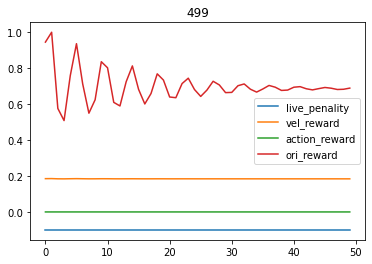

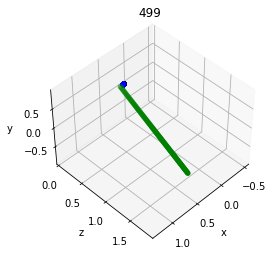

| eval  | E: 9 | S: 499 | R: 39.1941
| train | E: 10 | S: 499 | R: 39.9584 | D: 30.8 s | BR: 0.5945 | ALOSS: -9.0957 | CLOSS: 0.9046 | TLOSS: -0.9487 | TVAL: 0.8676 | AENT: -4.0000
| train | E: 11 | S: 549 | R: 42.2479 | D: 61.8 s | BR: 0.6200 | ALOSS: -9.5893 | CLOSS: 1.0677 | TLOSS: -1.0444 | TVAL: 0.8548 | AENT: -4.0000
| train | E: 12 | S: 599 | R: 28.4846 | D: 30.0 s | BR: 0.6076 | ALOSS: -10.0927 | CLOSS: 1.3458 | TLOSS: -1.1411 | TVAL: 0.8421 | AENT: -4.0000
| train | E: 13 | S: 649 | R: 29.7702 | D: 29.4 s | BR: 0.6084 | ALOSS: -10.5617 | CLOSS: 1.3621 | TLOSS: -1.2378 | TVAL: 0.8297 | AENT: -4.0000
| train | E: 14 | S: 699 | R: 44.4281 | D: 29.3 s | BR: 0.6249 | ALOSS: -11.0966 | CLOSS: 1.3722 | TLOSS: -1.3381 | TVAL: 0.8174 | AENT: -4.0000
| train | E: 15 | S: 749 | R: 23.3483 | D: 30.2 s | BR: 0.6182 | ALOSS: -11.5582 | CLOSS: 1.7230 | TLOSS: -1.4264 | TVAL: 0.8053 | AENT: -4.0000
| train | E: 16 | S: 799 | R: 33.9697 | D: 31.8 s | BR: 0.6307 | ALOSS: -12.0291 | CLOSS: 1.790

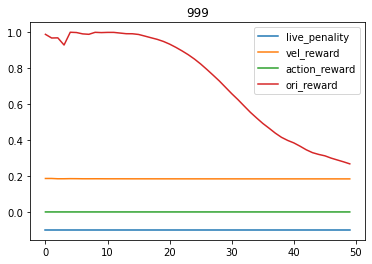

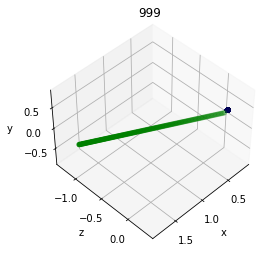

| eval  | E: 19 | S: 999 | R: 40.4694
| train | E: 20 | S: 999 | R: 27.8486 | D: 33.8 s | BR: 0.5919 | ALOSS: -13.7881 | CLOSS: 3.7103 | TLOSS: -1.8984 | TVAL: 0.7478 | AENT: -4.0000
| train | E: 21 | S: 1049 | R: 11.6434 | D: 59.9 s | BR: 0.5805 | ALOSS: -14.2097 | CLOSS: 3.5325 | TLOSS: -1.9980 | TVAL: 0.7368 | AENT: -4.0000
| train | E: 22 | S: 1099 | R: 26.0334 | D: 32.4 s | BR: 0.5701 | ALOSS: -14.6470 | CLOSS: 3.4687 | TLOSS: -2.0785 | TVAL: 0.7260 | AENT: -4.0000
| train | E: 23 | S: 1149 | R: 25.9217 | D: 29.0 s | BR: 0.5799 | ALOSS: -15.0486 | CLOSS: 3.6110 | TLOSS: -2.1839 | TVAL: 0.7154 | AENT: -4.0000
| train | E: 24 | S: 1199 | R: 21.5661 | D: 36.1 s | BR: 0.5539 | ALOSS: -15.5173 | CLOSS: 3.7758 | TLOSS: -2.2687 | TVAL: 0.7049 | AENT: -4.0000
| train | E: 25 | S: 1249 | R: 29.1680 | D: 28.5 s | BR: 0.5625 | ALOSS: -15.9117 | CLOSS: 3.5299 | TLOSS: -2.3554 | TVAL: 0.6946 | AENT: -4.0000
| train | E: 26 | S: 1299 | R: 22.6563 | D: 29.5 s | BR: 0.5590 | ALOSS: -16.2501 | CLO

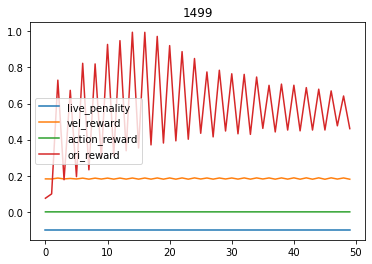

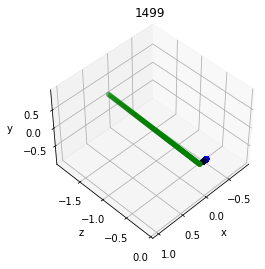

| eval  | E: 29 | S: 1499 | R: 32.8263
| train | E: 30 | S: 1499 | R: 18.6183 | D: 29.3 s | BR: 0.5492 | ALOSS: -17.8108 | CLOSS: 4.2266 | TLOSS: -2.7943 | TVAL: 0.6454 | AENT: -4.0000
| train | E: 31 | S: 1549 | R: 14.9164 | D: 59.5 s | BR: 0.5310 | ALOSS: -18.1027 | CLOSS: 5.2151 | TLOSS: -2.9140 | TVAL: 0.6360 | AENT: -4.0000
| train | E: 32 | S: 1599 | R: 23.8493 | D: 29.1 s | BR: 0.5342 | ALOSS: -18.4438 | CLOSS: 5.2026 | TLOSS: -3.0039 | TVAL: 0.6266 | AENT: -4.0000
| train | E: 33 | S: 1649 | R: 25.1741 | D: 31.1 s | BR: 0.5230 | ALOSS: -18.8233 | CLOSS: 5.2886 | TLOSS: -3.0783 | TVAL: 0.6175 | AENT: -4.0000
| train | E: 34 | S: 1699 | R: 39.6724 | D: 29.1 s | BR: 0.5323 | ALOSS: -19.1184 | CLOSS: 5.9638 | TLOSS: -3.1645 | TVAL: 0.6085 | AENT: -4.0000
| train | E: 35 | S: 1749 | R: 34.6105 | D: 30.9 s | BR: 0.5403 | ALOSS: -19.4673 | CLOSS: 6.6177 | TLOSS: -3.2508 | TVAL: 0.5997 | AENT: -4.0000
| train | E: 36 | S: 1799 | R: 21.8517 | D: 28.9 s | BR: 0.5229 | ALOSS: -19.6699 | C

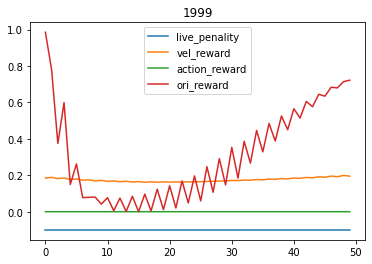

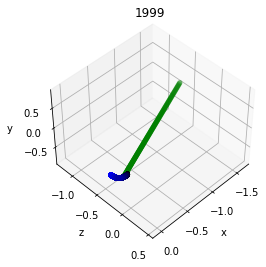

| eval  | E: 39 | S: 1999 | R: 19.2436
| train | E: 40 | S: 1999 | R: 30.2158 | D: 29.5 s | BR: 0.5639 | ALOSS: -20.8321 | CLOSS: 8.8949 | TLOSS: -3.6713 | TVAL: 0.5573 | AENT: -4.0000
| train | E: 41 | S: 2049 | R: 29.1522 | D: 59.9 s | BR: 0.5332 | ALOSS: -21.2334 | CLOSS: 6.7237 | TLOSS: -3.7733 | TVAL: 0.5492 | AENT: -4.0000
| train | E: 42 | S: 2099 | R: 26.4625 | D: 31.6 s | BR: 0.5467 | ALOSS: -21.4083 | CLOSS: 7.9140 | TLOSS: -3.8573 | TVAL: 0.5412 | AENT: -4.0000
| train | E: 43 | S: 2149 | R: 26.3869 | D: 29.4 s | BR: 0.5421 | ALOSS: -21.7601 | CLOSS: 7.3343 | TLOSS: -3.9459 | TVAL: 0.5334 | AENT: -4.0000
| train | E: 44 | S: 2199 | R: 34.0759 | D: 31.6 s | BR: 0.5500 | ALOSS: -21.9752 | CLOSS: 7.8916 | TLOSS: -3.9977 | TVAL: 0.5257 | AENT: -4.0000
| train | E: 45 | S: 2249 | R: 21.0984 | D: 29.2 s | BR: 0.5473 | ALOSS: -22.2180 | CLOSS: 9.3173 | TLOSS: -4.1078 | TVAL: 0.5181 | AENT: -4.0000
| train | E: 46 | S: 2299 | R: 32.1397 | D: 31.0 s | BR: 0.5656 | ALOSS: -22.3968 | C

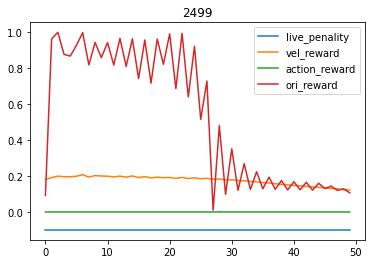

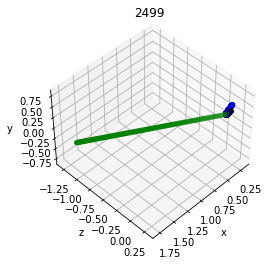

| eval  | E: 49 | S: 2499 | R: 30.0729
| train | E: 50 | S: 2499 | R: 21.4337 | D: 30.6 s | BR: 0.5617 | ALOSS: -23.2676 | CLOSS: 12.2693 | TLOSS: -4.5637 | TVAL: 0.4814 | AENT: -4.0000
| train | E: 51 | S: 2549 | R: 18.0922 | D: 61.5 s | BR: 0.5608 | ALOSS: -23.5199 | CLOSS: 10.5941 | TLOSS: -4.6564 | TVAL: 0.4744 | AENT: -4.0000
| train | E: 52 | S: 2599 | R: 28.4613 | D: 29.0 s | BR: 0.5412 | ALOSS: -23.8049 | CLOSS: 10.2226 | TLOSS: -4.7088 | TVAL: 0.4675 | AENT: -4.0000
| train | E: 53 | S: 2649 | R: 36.5792 | D: 33.2 s | BR: 0.5460 | ALOSS: -23.8363 | CLOSS: 10.3427 | TLOSS: -4.8340 | TVAL: 0.4607 | AENT: -4.0000
| train | E: 54 | S: 2699 | R: 28.8114 | D: 29.6 s | BR: 0.5474 | ALOSS: -24.1757 | CLOSS: 9.1342 | TLOSS: -4.9055 | TVAL: 0.4540 | AENT: -4.0000
| train | E: 55 | S: 2749 | R: 37.0957 | D: 32.5 s | BR: 0.5577 | ALOSS: -24.3227 | CLOSS: 10.2071 | TLOSS: -5.0135 | TVAL: 0.4474 | AENT: -4.0000
| train | E: 56 | S: 2799 | R: 30.3381 | D: 29.9 s | BR: 0.5678 | ALOSS: -24.586

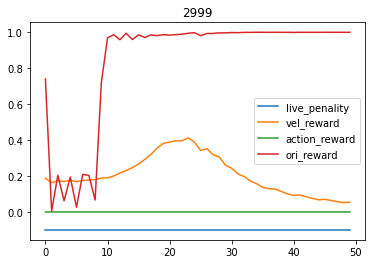

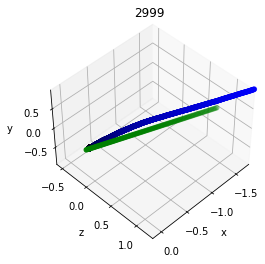

| eval  | E: 59 | S: 2999 | R: 47.4282
| train | E: 60 | S: 2999 | R: 35.1266 | D: 29.8 s | BR: 0.5636 | ALOSS: -25.1669 | CLOSS: 12.1594 | TLOSS: -5.4132 | TVAL: 0.4158 | AENT: -4.0000
| train | E: 61 | S: 3049 | R: 30.2177 | D: 59.4 s | BR: 0.5719 | ALOSS: -25.5499 | CLOSS: 9.4182 | TLOSS: -5.4774 | TVAL: 0.4098 | AENT: -4.0000
| train | E: 62 | S: 3099 | R: 17.6337 | D: 32.2 s | BR: 0.5553 | ALOSS: -25.5671 | CLOSS: 11.6766 | TLOSS: -5.5506 | TVAL: 0.4038 | AENT: -4.0000
| train | E: 63 | S: 3149 | R: 21.0914 | D: 29.7 s | BR: 0.5644 | ALOSS: -25.6935 | CLOSS: 12.1416 | TLOSS: -5.6536 | TVAL: 0.3979 | AENT: -4.0000
| train | E: 64 | S: 3199 | R: 31.6381 | D: 32.9 s | BR: 0.5544 | ALOSS: -25.8995 | CLOSS: 11.5429 | TLOSS: -5.6853 | TVAL: 0.3922 | AENT: -4.0000
| train | E: 65 | S: 3249 | R: 37.5989 | D: 30.6 s | BR: 0.5430 | ALOSS: -25.9817 | CLOSS: 13.7789 | TLOSS: -5.7815 | TVAL: 0.3865 | AENT: -4.0000
| train | E: 66 | S: 3299 | R: 25.9339 | D: 31.0 s | BR: 0.5456 | ALOSS: -26.008

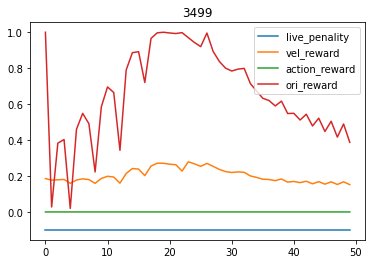

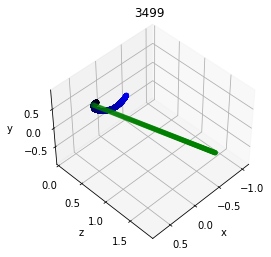

| eval  | E: 69 | S: 3499 | R: 38.1680
| train | E: 70 | S: 3499 | R: 22.8615 | D: 30.4 s | BR: 0.5620 | ALOSS: -26.5053 | CLOSS: 15.6079 | TLOSS: -6.0684 | TVAL: 0.3597 | AENT: -4.0000
| train | E: 71 | S: 3549 | R: 24.1569 | D: 57.8 s | BR: 0.5484 | ALOSS: -26.7898 | CLOSS: 13.1338 | TLOSS: -6.1210 | TVAL: 0.3546 | AENT: -4.0000
| train | E: 72 | S: 3599 | R: 13.4270 | D: 28.9 s | BR: 0.5404 | ALOSS: -26.8451 | CLOSS: 14.3427 | TLOSS: -6.1075 | TVAL: 0.3496 | AENT: -4.0000
| train | E: 73 | S: 3649 | R: 20.4890 | D: 32.3 s | BR: 0.5461 | ALOSS: -27.1551 | CLOSS: 12.9347 | TLOSS: -6.2065 | TVAL: 0.3447 | AENT: -4.0000
| train | E: 74 | S: 3699 | R: 21.6016 | D: 29.1 s | BR: 0.5313 | ALOSS: -27.2038 | CLOSS: 13.7283 | TLOSS: -6.2779 | TVAL: 0.3398 | AENT: -4.0000
| train | E: 75 | S: 3749 | R: 33.4314 | D: 32.2 s | BR: 0.5458 | ALOSS: -27.1073 | CLOSS: 15.0788 | TLOSS: -6.3910 | TVAL: 0.3350 | AENT: -4.0000
| train | E: 76 | S: 3799 | R: 35.6292 | D: 28.9 s | BR: 0.5509 | ALOSS: -27.36

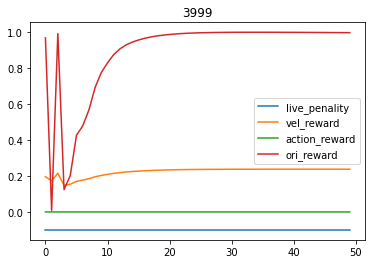

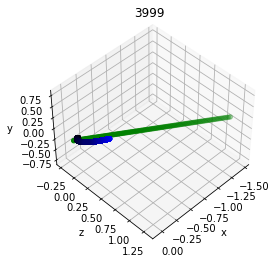

| eval  | E: 79 | S: 3999 | R: 50.7019
| train | E: 80 | S: 3999 | R: 28.9682 | D: 32.4 s | BR: 0.5434 | ALOSS: -27.8404 | CLOSS: 14.1956 | TLOSS: -6.6414 | TVAL: 0.3120 | AENT: -4.0000
| train | E: 81 | S: 4049 | R: 25.5014 | D: 59.5 s | BR: 0.5469 | ALOSS: -27.9754 | CLOSS: 15.0284 | TLOSS: -6.6842 | TVAL: 0.3076 | AENT: -4.0000
| train | E: 82 | S: 4099 | R: 31.4415 | D: 29.1 s | BR: 0.5338 | ALOSS: -27.9087 | CLOSS: 16.3141 | TLOSS: -6.6879 | TVAL: 0.3033 | AENT: -4.0000
| train | E: 83 | S: 4149 | R: 38.2855 | D: 30.8 s | BR: 0.5480 | ALOSS: -28.1300 | CLOSS: 13.9989 | TLOSS: -6.8012 | TVAL: 0.2991 | AENT: -4.0000
| train | E: 84 | S: 4199 | R: 23.3486 | D: 38.6 s | BR: 0.5536 | ALOSS: -28.1591 | CLOSS: 13.9339 | TLOSS: -6.8977 | TVAL: 0.2949 | AENT: -4.0000
| train | E: 85 | S: 4249 | R: 46.6048 | D: 57.5 s | BR: 0.5542 | ALOSS: -28.2774 | CLOSS: 15.2852 | TLOSS: -6.8638 | TVAL: 0.2908 | AENT: -4.0000
| train | E: 86 | S: 4299 | R: 17.1475 | D: 57.6 s | BR: 0.5473 | ALOSS: -28.45

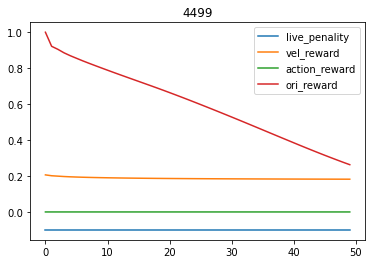

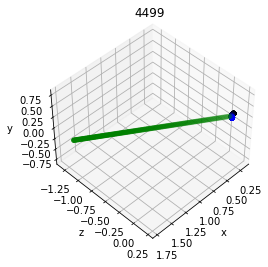

| eval  | E: 89 | S: 4499 | R: 34.2969
| train | E: 90 | S: 4499 | R: 21.6420 | D: 55.6 s | BR: 0.5461 | ALOSS: -28.8388 | CLOSS: 15.6608 | TLOSS: -6.8202 | TVAL: 0.2711 | AENT: -4.0000
| train | E: 91 | S: 4549 | R: 39.9876 | D: 90.4 s | BR: 0.5384 | ALOSS: -28.5585 | CLOSS: 18.8173 | TLOSS: -7.3247 | TVAL: 0.2674 | AENT: -4.0000
| train | E: 92 | S: 4599 | R: 24.3537 | D: 62.3 s | BR: 0.5532 | ALOSS: -29.0656 | CLOSS: 10.7421 | TLOSS: -7.3824 | TVAL: 0.2636 | AENT: -4.0000
| train | E: 93 | S: 4649 | R: 24.2867 | D: 55.6 s | BR: 0.5385 | ALOSS: -29.0610 | CLOSS: 12.0410 | TLOSS: -7.3225 | TVAL: 0.2599 | AENT: -4.0000
| train | E: 94 | S: 4699 | R: 34.4654 | D: 58.6 s | BR: 0.5598 | ALOSS: -29.0071 | CLOSS: 17.2577 | TLOSS: -7.2996 | TVAL: 0.2563 | AENT: -4.0000
| train | E: 95 | S: 4749 | R: 20.1417 | D: 56.6 s | BR: 0.5470 | ALOSS: -29.1334 | CLOSS: 15.7281 | TLOSS: -7.2572 | TVAL: 0.2527 | AENT: -4.0000
| train | E: 96 | S: 4799 | R: 24.7016 | D: 56.1 s | BR: 0.5652 | ALOSS: -29.18

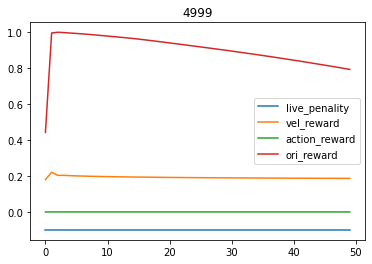

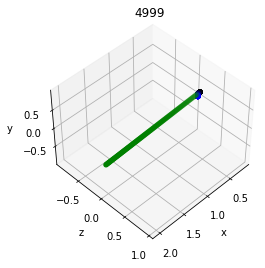

| eval  | E: 99 | S: 4999 | R: 49.7301
| train | E: 100 | S: 4999 | R: 38.1711 | D: 29.4 s | BR: 0.5454 | ALOSS: -29.5646 | CLOSS: 14.3580 | TLOSS: -7.5593 | TVAL: 0.2359 | AENT: -4.0000
| train | E: 101 | S: 5049 | R: 37.7928 | D: 61.2 s | BR: 0.5567 | ALOSS: -29.4403 | CLOSS: 16.2601 | TLOSS: -7.7137 | TVAL: 0.2326 | AENT: -4.0000
| train | E: 102 | S: 5099 | R: 18.5191 | D: 29.6 s | BR: 0.5510 | ALOSS: -29.6552 | CLOSS: 14.5681 | TLOSS: -7.7932 | TVAL: 0.2293 | AENT: -4.0000
| train | E: 103 | S: 5149 | R: 36.3530 | D: 29.2 s | BR: 0.5462 | ALOSS: -29.4572 | CLOSS: 18.4868 | TLOSS: -7.8518 | TVAL: 0.2261 | AENT: -4.0000
| train | E: 104 | S: 5199 | R: 24.0158 | D: 29.7 s | BR: 0.5495 | ALOSS: -29.6615 | CLOSS: 15.8077 | TLOSS: -7.5414 | TVAL: 0.2230 | AENT: -4.0000
| train | E: 105 | S: 5249 | R: 32.9812 | D: 29.8 s | BR: 0.5371 | ALOSS: -29.5728 | CLOSS: 19.5773 | TLOSS: -7.8127 | TVAL: 0.2200 | AENT: -4.0000
| train | E: 106 | S: 5299 | R: 35.0918 | D: 29.5 s | BR: 0.5562 | ALOSS:

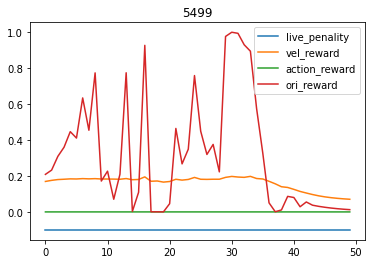

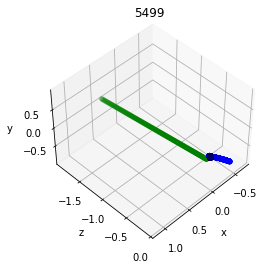

| eval  | E: 109 | S: 5499 | R: 18.7816
| train | E: 110 | S: 5499 | R: 22.3782 | D: 29.5 s | BR: 0.5685 | ALOSS: -29.9512 | CLOSS: 14.9196 | TLOSS: -7.8796 | TVAL: 0.2054 | AENT: -4.0000
| train | E: 111 | S: 5549 | R: 12.5082 | D: 59.4 s | BR: 0.5455 | ALOSS: -29.9155 | CLOSS: 17.0592 | TLOSS: -7.4241 | TVAL: 0.2026 | AENT: -4.0000
| train | E: 112 | S: 5599 | R: 23.5820 | D: 29.9 s | BR: 0.5499 | ALOSS: -29.9654 | CLOSS: 16.4684 | TLOSS: -7.8161 | TVAL: 0.2000 | AENT: -4.0000
| train | E: 113 | S: 5649 | R: 32.6458 | D: 29.5 s | BR: 0.5503 | ALOSS: -30.0549 | CLOSS: 16.6545 | TLOSS: -7.7587 | TVAL: 0.1973 | AENT: -4.0000
| train | E: 114 | S: 5699 | R: 14.0337 | D: 31.8 s | BR: 0.5386 | ALOSS: -29.8751 | CLOSS: 17.5331 | TLOSS: -7.4725 | TVAL: 0.1948 | AENT: -4.0000
| train | E: 115 | S: 5749 | R: 15.9347 | D: 29.7 s | BR: 0.5486 | ALOSS: -30.0749 | CLOSS: 15.0643 | TLOSS: -8.0779 | TVAL: 0.1922 | AENT: -4.0000
| train | E: 116 | S: 5799 | R: 18.2707 | D: 29.3 s | BR: 0.5500 | ALOSS

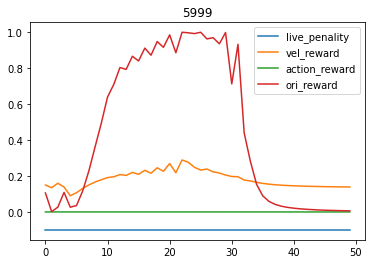

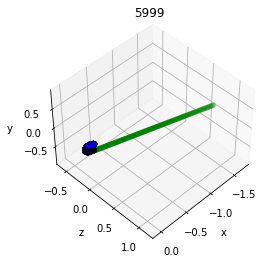

| eval  | E: 119 | S: 5999 | R: 26.4565
| train | E: 120 | S: 5999 | R: 34.3818 | D: 54.5 s | BR: 0.5584 | ALOSS: -30.3864 | CLOSS: 16.1295 | TLOSS: -7.7485 | TVAL: 0.1794 | AENT: -4.0000
| train | E: 121 | S: 6049 | R: 30.9706 | D: 110.8 s | BR: 0.5594 | ALOSS: -30.3097 | CLOSS: 13.3455 | TLOSS: -8.1649 | TVAL: 0.1770 | AENT: -4.0000
| train | E: 122 | S: 6099 | R: 18.9748 | D: 53.9 s | BR: 0.5514 | ALOSS: -30.3870 | CLOSS: 16.2706 | TLOSS: -8.2166 | TVAL: 0.1746 | AENT: -4.0000
| train | E: 123 | S: 6149 | R: 26.6086 | D: 43.4 s | BR: 0.5541 | ALOSS: -30.5757 | CLOSS: 14.9249 | TLOSS: -7.7523 | TVAL: 0.1723 | AENT: -4.0000
| train | E: 124 | S: 6199 | R: 23.0901 | D: 51.5 s | BR: 0.5583 | ALOSS: -30.3742 | CLOSS: 18.5047 | TLOSS: -7.4673 | TVAL: 0.1701 | AENT: -4.0000
| train | E: 125 | S: 6249 | R: 22.9690 | D: 57.3 s | BR: 0.5346 | ALOSS: -30.6227 | CLOSS: 13.4599 | TLOSS: -8.3368 | TVAL: 0.1679 | AENT: -4.0000
| train | E: 126 | S: 6299 | R: 24.3341 | D: 56.3 s | BR: 0.5470 | ALOS

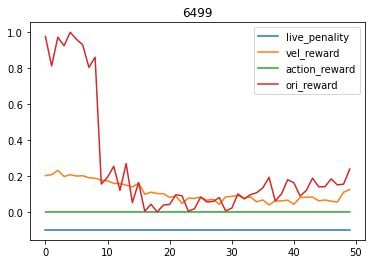

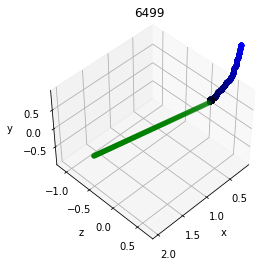

| eval  | E: 129 | S: 6499 | R: 13.2124
| train | E: 130 | S: 6499 | R: 16.2146 | D: 53.6 s | BR: 0.5349 | ALOSS: -30.5310 | CLOSS: 15.3787 | TLOSS: -8.5169 | TVAL: 0.1568 | AENT: -4.0000
| train | E: 131 | S: 6549 | R: 27.9835 | D: 66.3 s | BR: 0.5553 | ALOSS: -30.4579 | CLOSS: 17.4810 | TLOSS: -8.7300 | TVAL: 0.1546 | AENT: -4.0000
| train | E: 132 | S: 6599 | R: 21.0882 | D: 29.5 s | BR: 0.5390 | ALOSS: -30.4496 | CLOSS: 17.8203 | TLOSS: -8.9725 | TVAL: 0.1524 | AENT: -4.0000
| train | E: 133 | S: 6649 | R: 15.3867 | D: 33.0 s | BR: 0.5537 | ALOSS: -30.4500 | CLOSS: 17.0091 | TLOSS: -8.8426 | TVAL: 0.1503 | AENT: -4.0000
| train | E: 134 | S: 6699 | R: 13.9157 | D: 32.5 s | BR: 0.5346 | ALOSS: -30.3873 | CLOSS: 18.5435 | TLOSS: -9.0044 | TVAL: 0.1481 | AENT: -4.0000
| train | E: 135 | S: 6749 | R: 26.1909 | D: 29.4 s | BR: 0.5185 | ALOSS: -30.4101 | CLOSS: 16.5848 | TLOSS: -8.7767 | TVAL: 0.1460 | AENT: -4.0000
| train | E: 136 | S: 6799 | R: 46.4840 | D: 29.7 s | BR: 0.5405 | ALOSS

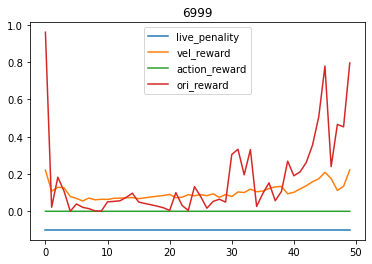

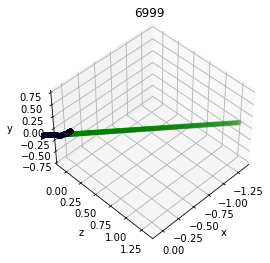

| eval  | E: 139 | S: 6999 | R: 8.7206
| train | E: 140 | S: 6999 | R: 36.3645 | D: 30.5 s | BR: 0.5437 | ALOSS: -30.5267 | CLOSS: 14.8512 | TLOSS: -8.7397 | TVAL: 0.1364 | AENT: -4.0000
| train | E: 141 | S: 7049 | R: 13.1766 | D: 60.4 s | BR: 0.5298 | ALOSS: -30.7028 | CLOSS: 12.5317 | TLOSS: -8.6380 | TVAL: 0.1346 | AENT: -4.0000
| train | E: 142 | S: 7099 | R: 16.3159 | D: 29.4 s | BR: 0.5252 | ALOSS: -30.5875 | CLOSS: 15.0660 | TLOSS: -8.9216 | TVAL: 0.1327 | AENT: -4.0000
| train | E: 143 | S: 7149 | R: 32.4017 | D: 29.7 s | BR: 0.5442 | ALOSS: -30.7831 | CLOSS: 16.8427 | TLOSS: -8.7560 | TVAL: 0.1309 | AENT: -4.0000
| train | E: 144 | S: 7199 | R: 27.4963 | D: 30.4 s | BR: 0.5315 | ALOSS: -30.6138 | CLOSS: 16.1651 | TLOSS: -8.7496 | TVAL: 0.1292 | AENT: -4.0000
| train | E: 145 | S: 7249 | R: 10.2465 | D: 30.1 s | BR: 0.5370 | ALOSS: -30.7203 | CLOSS: 15.4978 | TLOSS: -8.6348 | TVAL: 0.1274 | AENT: -4.0000
| train | E: 146 | S: 7299 | R: 13.2243 | D: 30.0 s | BR: 0.5284 | ALOSS:

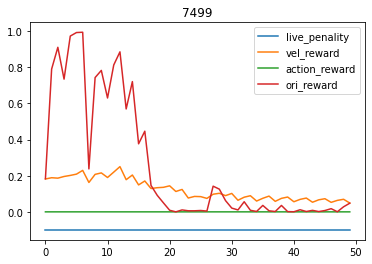

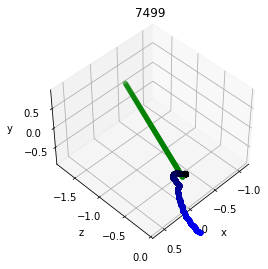

| eval  | E: 149 | S: 7499 | R: 13.8776
| train | E: 150 | S: 7499 | R: 17.5358 | D: 30.3 s | BR: 0.5292 | ALOSS: -30.7843 | CLOSS: 17.3931 | TLOSS: -8.1482 | TVAL: 0.1199 | AENT: -4.0000
| train | E: 151 | S: 7549 | R: 11.5762 | D: 61.8 s | BR: 0.5399 | ALOSS: -31.2114 | CLOSS: 13.5845 | TLOSS: -7.1717 | TVAL: 0.1184 | AENT: -4.0000
| train | E: 152 | S: 7599 | R: 7.4087 | D: 30.8 s | BR: 0.5257 | ALOSS: -30.7297 | CLOSS: 21.9680 | TLOSS: -7.7133 | TVAL: 0.1170 | AENT: -4.0000
| train | E: 153 | S: 7649 | R: 13.9263 | D: 29.3 s | BR: 0.5201 | ALOSS: -30.8850 | CLOSS: 15.9589 | TLOSS: -7.5452 | TVAL: 0.1156 | AENT: -4.0000
| train | E: 154 | S: 7699 | R: 21.0626 | D: 29.3 s | BR: 0.5168 | ALOSS: -30.9678 | CLOSS: 17.1757 | TLOSS: -7.3342 | TVAL: 0.1143 | AENT: -4.0000
| train | E: 155 | S: 7749 | R: 11.5006 | D: 29.5 s | BR: 0.5278 | ALOSS: -31.0632 | CLOSS: 13.1315 | TLOSS: -7.2912 | TVAL: 0.1129 | AENT: -4.0000
| train | E: 156 | S: 7799 | R: 19.8538 | D: 32.8 s | BR: 0.5142 | ALOSS:

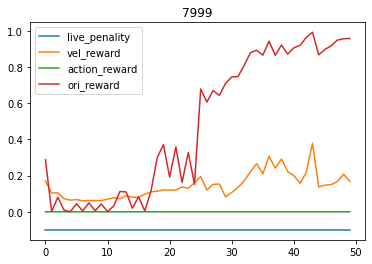

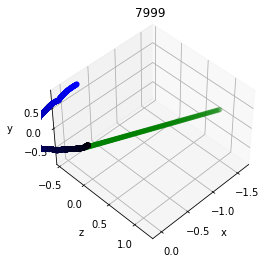

| eval  | E: 159 | S: 7999 | R: 26.2336
| train | E: 160 | S: 7999 | R: 16.8634 | D: 29.8 s | BR: 0.5202 | ALOSS: -31.0411 | CLOSS: 16.8478 | TLOSS: -7.5211 | TVAL: 0.1064 | AENT: -4.0000
| train | E: 161 | S: 8049 | R: 23.2280 | D: 58.0 s | BR: 0.5247 | ALOSS: -31.1182 | CLOSS: 17.1349 | TLOSS: -7.7372 | TVAL: 0.1051 | AENT: -4.0000
| train | E: 162 | S: 8099 | R: 20.4321 | D: 32.6 s | BR: 0.5248 | ALOSS: -31.2719 | CLOSS: 14.3074 | TLOSS: -6.9943 | TVAL: 0.1038 | AENT: -4.0000
| train | E: 163 | S: 8149 | R: 28.0652 | D: 29.2 s | BR: 0.5300 | ALOSS: -31.3023 | CLOSS: 13.9486 | TLOSS: -6.7444 | TVAL: 0.1027 | AENT: -4.0000
| train | E: 164 | S: 8199 | R: 35.7426 | D: 29.4 s | BR: 0.5253 | ALOSS: -31.3293 | CLOSS: 12.7930 | TLOSS: -6.9273 | TVAL: 0.1015 | AENT: -4.0000
| train | E: 165 | S: 8249 | R: 33.8669 | D: 29.2 s | BR: 0.5060 | ALOSS: -31.1042 | CLOSS: 19.0879 | TLOSS: -7.1422 | TVAL: 0.1003 | AENT: -4.0000
| train | E: 166 | S: 8299 | R: 36.8233 | D: 30.6 s | BR: 0.5142 | ALOSS

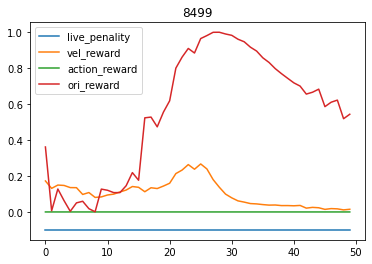

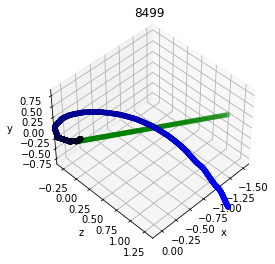

| eval  | E: 169 | S: 8499 | R: 27.9790
| train | E: 170 | S: 8499 | R: 36.1670 | D: 29.8 s | BR: 0.5284 | ALOSS: -31.4341 | CLOSS: 14.2838 | TLOSS: -6.7142 | TVAL: 0.0949 | AENT: -4.0000
| train | E: 171 | S: 8549 | R: 30.1545 | D: 62.1 s | BR: 0.5082 | ALOSS: -31.2794 | CLOSS: 17.9749 | TLOSS: -6.5679 | TVAL: 0.0938 | AENT: -4.0000
| train | E: 172 | S: 8599 | R: 31.7907 | D: 31.9 s | BR: 0.5154 | ALOSS: -31.4013 | CLOSS: 13.2589 | TLOSS: -7.6235 | TVAL: 0.0927 | AENT: -4.0000
| train | E: 173 | S: 8649 | R: 31.8611 | D: 30.0 s | BR: 0.5172 | ALOSS: -31.3612 | CLOSS: 14.5026 | TLOSS: -8.1878 | TVAL: 0.0915 | AENT: -4.0000
| train | E: 174 | S: 8699 | R: 9.5715 | D: 32.8 s | BR: 0.5235 | ALOSS: -31.2542 | CLOSS: 20.0951 | TLOSS: -7.3763 | TVAL: 0.0902 | AENT: -4.0000
| train | E: 175 | S: 8749 | R: 35.8636 | D: 29.7 s | BR: 0.5172 | ALOSS: -31.1920 | CLOSS: 17.4400 | TLOSS: -7.4074 | TVAL: 0.0891 | AENT: -4.0000
| train | E: 176 | S: 8799 | R: 14.5751 | D: 32.5 s | BR: 0.5190 | ALOSS:

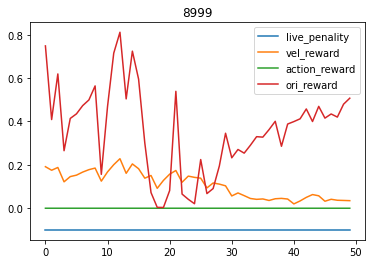

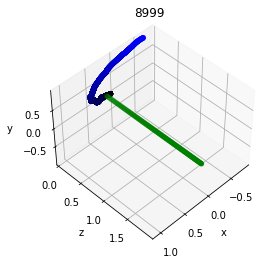

| eval  | E: 179 | S: 8999 | R: 18.4562
| train | E: 180 | S: 8999 | R: 40.5374 | D: 31.8 s | BR: 0.5162 | ALOSS: -31.1807 | CLOSS: 19.5212 | TLOSS: -6.9757 | TVAL: 0.0834 | AENT: -4.0000
| train | E: 181 | S: 9049 | R: 20.8313 | D: 60.7 s | BR: 0.5226 | ALOSS: -31.3624 | CLOSS: 12.6972 | TLOSS: -8.1651 | TVAL: 0.0823 | AENT: -4.0000
| train | E: 182 | S: 9099 | R: 13.1033 | D: 29.7 s | BR: 0.5220 | ALOSS: -31.2862 | CLOSS: 18.2691 | TLOSS: -7.0429 | TVAL: 0.0812 | AENT: -4.0000
| train | E: 183 | S: 9149 | R: 17.3951 | D: 32.9 s | BR: 0.5107 | ALOSS: -31.3702 | CLOSS: 14.0702 | TLOSS: -7.1795 | TVAL: 0.0802 | AENT: -4.0000
| train | E: 184 | S: 9199 | R: 21.4049 | D: 29.7 s | BR: 0.5293 | ALOSS: -31.3716 | CLOSS: 18.4232 | TLOSS: -6.1189 | TVAL: 0.0793 | AENT: -4.0000
| train | E: 185 | S: 9249 | R: 15.5231 | D: 31.8 s | BR: 0.5141 | ALOSS: -31.5016 | CLOSS: 13.2538 | TLOSS: -7.4810 | TVAL: 0.0784 | AENT: -4.0000
| train | E: 186 | S: 9299 | R: 17.7403 | D: 29.8 s | BR: 0.4966 | ALOSS

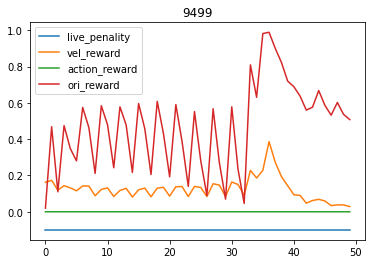

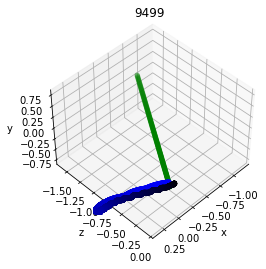

| eval  | E: 189 | S: 9499 | R: 24.8627
| train | E: 190 | S: 9499 | R: 10.7835 | D: 30.6 s | BR: 0.5028 | ALOSS: -31.1988 | CLOSS: 17.0717 | TLOSS: -6.6186 | TVAL: 0.0741 | AENT: -4.0000
| train | E: 191 | S: 9549 | R: 34.0121 | D: 60.8 s | BR: 0.5052 | ALOSS: -31.3739 | CLOSS: 15.7816 | TLOSS: -6.0550 | TVAL: 0.0733 | AENT: -4.0000
| train | E: 192 | S: 9599 | R: 25.2235 | D: 32.8 s | BR: 0.5221 | ALOSS: -31.5555 | CLOSS: 14.4833 | TLOSS: -5.2410 | TVAL: 0.0725 | AENT: -4.0000
| train | E: 193 | S: 9649 | R: 6.4142 | D: 30.5 s | BR: 0.5115 | ALOSS: -31.5808 | CLOSS: 15.3792 | TLOSS: -4.7999 | TVAL: 0.0718 | AENT: -4.0000
| train | E: 194 | S: 9699 | R: 6.5783 | D: 31.4 s | BR: 0.5096 | ALOSS: -31.0761 | CLOSS: 20.3270 | TLOSS: -5.7333 | TVAL: 0.0712 | AENT: -4.0000
| train | E: 195 | S: 9749 | R: 25.6412 | D: 30.1 s | BR: 0.5210 | ALOSS: -31.4351 | CLOSS: 15.5645 | TLOSS: -6.3049 | TVAL: 0.0703 | AENT: -4.0000
| train | E: 196 | S: 9799 | R: 16.5663 | D: 32.3 s | BR: 0.5115 | ALOSS: 

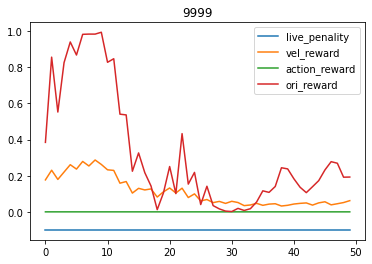

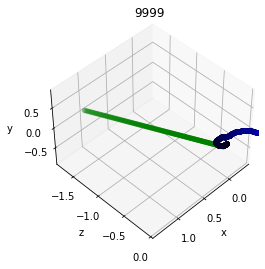

| eval  | E: 199 | S: 9999 | R: 16.9762
| train | E: 200 | S: 9999 | R: 19.4951 | D: 29.6 s | BR: 0.5196 | ALOSS: -31.3193 | CLOSS: 16.3283 | TLOSS: -5.7735 | TVAL: 0.0669 | AENT: -4.0000
| train | E: 201 | S: 10049 | R: 23.8209 | D: 66.0 s | BR: 0.5178 | ALOSS: -31.1372 | CLOSS: 19.9630 | TLOSS: -6.2902 | TVAL: 0.0661 | AENT: -4.0000
| train | E: 202 | S: 10099 | R: 21.2098 | D: 29.3 s | BR: 0.5129 | ALOSS: -31.5498 | CLOSS: 11.7708 | TLOSS: -4.9093 | TVAL: 0.0654 | AENT: -4.0000
| train | E: 203 | S: 10149 | R: 23.3444 | D: 28.9 s | BR: 0.5026 | ALOSS: -31.3729 | CLOSS: 14.1319 | TLOSS: -4.3768 | TVAL: 0.0647 | AENT: -4.0000
| train | E: 204 | S: 10199 | R: 21.0670 | D: 30.2 s | BR: 0.5030 | ALOSS: -31.3676 | CLOSS: 14.5697 | TLOSS: -4.5903 | TVAL: 0.0642 | AENT: -4.0000
| train | E: 205 | S: 10249 | R: 29.7305 | D: 32.2 s | BR: 0.5033 | ALOSS: -31.0911 | CLOSS: 22.2291 | TLOSS: -4.9763 | TVAL: 0.0636 | AENT: -4.0000
| train | E: 206 | S: 10299 | R: 23.2677 | D: 31.4 s | BR: 0.5037 |

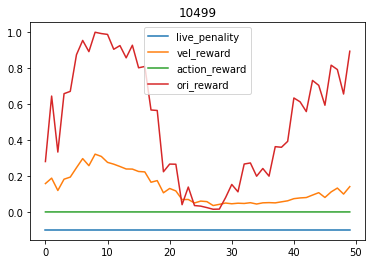

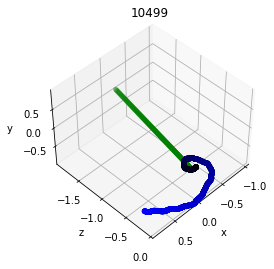

| eval  | E: 209 | S: 10499 | R: 26.9263
| train | E: 210 | S: 10499 | R: 18.4674 | D: 29.5 s | BR: 0.5115 | ALOSS: -31.4185 | CLOSS: 13.5706 | TLOSS: -4.3544 | TVAL: 0.0608 | AENT: -4.0000
| train | E: 211 | S: 10549 | R: 18.9003 | D: 61.3 s | BR: 0.5024 | ALOSS: -31.2400 | CLOSS: 19.6814 | TLOSS: -4.0207 | TVAL: 0.0602 | AENT: -4.0000
| train | E: 212 | S: 10599 | R: 19.3560 | D: 29.6 s | BR: 0.4982 | ALOSS: -31.2522 | CLOSS: 13.8789 | TLOSS: -4.4555 | TVAL: 0.0597 | AENT: -4.0000
| train | E: 213 | S: 10649 | R: 16.5115 | D: 32.3 s | BR: 0.5107 | ALOSS: -31.2485 | CLOSS: 16.5285 | TLOSS: -4.8008 | TVAL: 0.0591 | AENT: -4.0000
| train | E: 214 | S: 10699 | R: 16.6776 | D: 29.9 s | BR: 0.5057 | ALOSS: -31.0418 | CLOSS: 20.8402 | TLOSS: -4.5182 | TVAL: 0.0584 | AENT: -4.0000
| train | E: 215 | S: 10749 | R: 17.6352 | D: 31.9 s | BR: 0.5001 | ALOSS: -31.1334 | CLOSS: 15.3613 | TLOSS: -4.5236 | TVAL: 0.0578 | AENT: -4.0000
| train | E: 216 | S: 10799 | R: 18.7340 | D: 29.4 s | BR: 0.5072

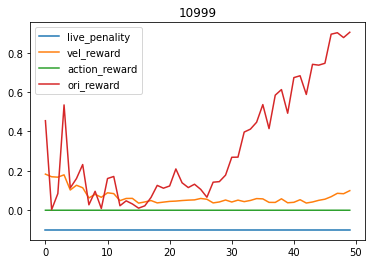

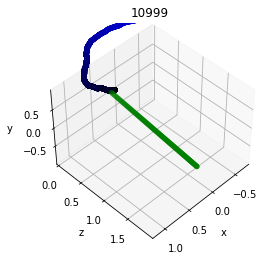

| eval  | E: 219 | S: 10999 | R: 14.4132
| train | E: 220 | S: 10999 | R: 24.2909 | D: 31.2 s | BR: 0.4827 | ALOSS: -31.0539 | CLOSS: 15.4623 | TLOSS: -3.9482 | TVAL: 0.0553 | AENT: -4.0000
| train | E: 221 | S: 11049 | R: 28.0010 | D: 62.3 s | BR: 0.5131 | ALOSS: -30.9356 | CLOSS: 17.4659 | TLOSS: -3.9858 | TVAL: 0.0547 | AENT: -4.0000
| train | E: 222 | S: 11099 | R: 30.0266 | D: 35.8 s | BR: 0.4944 | ALOSS: -31.0321 | CLOSS: 15.8075 | TLOSS: -3.2418 | TVAL: 0.0542 | AENT: -4.0000
| train | E: 223 | S: 11149 | R: 32.3331 | D: 29.3 s | BR: 0.5105 | ALOSS: -30.9480 | CLOSS: 18.1486 | TLOSS: -2.5057 | TVAL: 0.0538 | AENT: -4.0000
| train | E: 224 | S: 11199 | R: 27.3905 | D: 29.5 s | BR: 0.5098 | ALOSS: -31.0538 | CLOSS: 15.9289 | TLOSS: -1.9804 | TVAL: 0.0535 | AENT: -4.0000
| train | E: 225 | S: 11249 | R: 29.6529 | D: 29.5 s | BR: 0.5022 | ALOSS: -30.8860 | CLOSS: 19.3098 | TLOSS: -2.9473 | TVAL: 0.0532 | AENT: -4.0000
| train | E: 226 | S: 11299 | R: 30.1130 | D: 29.6 s | BR: 0.4962

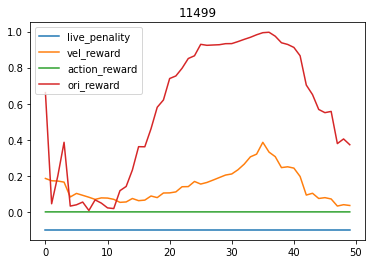

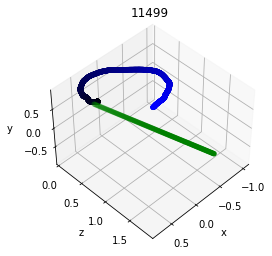

| eval  | E: 229 | S: 11499 | R: 30.9754
| train | E: 230 | S: 11499 | R: 25.2268 | D: 29.4 s | BR: 0.5116 | ALOSS: -30.8275 | CLOSS: 17.6458 | TLOSS: -2.2446 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 231 | S: 11549 | R: 20.0737 | D: 58.7 s | BR: 0.5007 | ALOSS: -30.8207 | CLOSS: 15.2855 | TLOSS: -2.5791 | TVAL: 0.0509 | AENT: -4.0000
| train | E: 232 | S: 11599 | R: 22.0682 | D: 29.4 s | BR: 0.4952 | ALOSS: -30.7938 | CLOSS: 18.0951 | TLOSS: -2.5077 | TVAL: 0.0505 | AENT: -4.0000
| train | E: 233 | S: 11649 | R: 27.0247 | D: 29.9 s | BR: 0.5089 | ALOSS: -30.6256 | CLOSS: 17.7644 | TLOSS: -3.3774 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 234 | S: 11699 | R: 23.0242 | D: 32.3 s | BR: 0.5082 | ALOSS: -30.5540 | CLOSS: 17.4350 | TLOSS: -2.7332 | TVAL: 0.0496 | AENT: -4.0000
| train | E: 235 | S: 11749 | R: 28.7503 | D: 29.6 s | BR: 0.5109 | ALOSS: -30.8427 | CLOSS: 15.5744 | TLOSS: -2.9380 | TVAL: 0.0492 | AENT: -4.0000
| train | E: 236 | S: 11799 | R: 28.5322 | D: 31.4 s | BR: 0.4904

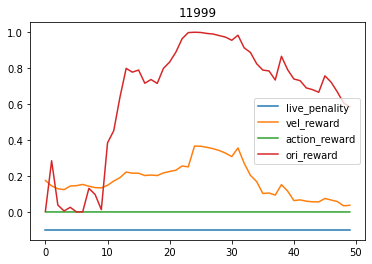

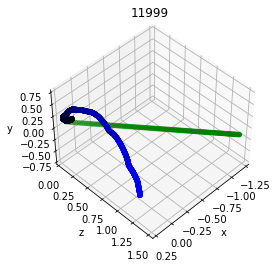

| eval  | E: 239 | S: 11999 | R: 36.3539
| train | E: 240 | S: 11999 | R: 23.9552 | D: 32.2 s | BR: 0.5051 | ALOSS: -30.4919 | CLOSS: 17.6783 | TLOSS: -1.8580 | TVAL: 0.0470 | AENT: -4.0000
| train | E: 241 | S: 12049 | R: 30.9032 | D: 63.1 s | BR: 0.5142 | ALOSS: -30.3116 | CLOSS: 18.8698 | TLOSS: -2.1145 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 242 | S: 12099 | R: 28.9762 | D: 30.2 s | BR: 0.5083 | ALOSS: -30.2870 | CLOSS: 16.6761 | TLOSS: -3.3847 | TVAL: 0.0463 | AENT: -4.0000
| train | E: 243 | S: 12149 | R: 35.4524 | D: 31.6 s | BR: 0.5127 | ALOSS: -30.2388 | CLOSS: 17.2722 | TLOSS: -3.7696 | TVAL: 0.0458 | AENT: -4.0000
| train | E: 244 | S: 12199 | R: 38.5193 | D: 29.6 s | BR: 0.5146 | ALOSS: -30.2914 | CLOSS: 15.9296 | TLOSS: -3.7626 | TVAL: 0.0453 | AENT: -4.0000
| train | E: 245 | S: 12249 | R: 40.9838 | D: 31.6 s | BR: 0.5199 | ALOSS: -30.2471 | CLOSS: 13.7968 | TLOSS: -3.4613 | TVAL: 0.0447 | AENT: -4.0000
| train | E: 246 | S: 12299 | R: 36.6954 | D: 29.8 s | BR: 0.5012

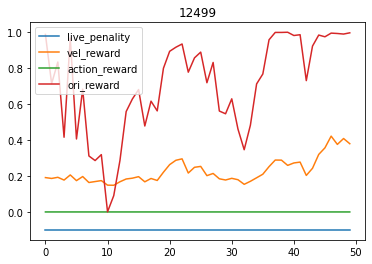

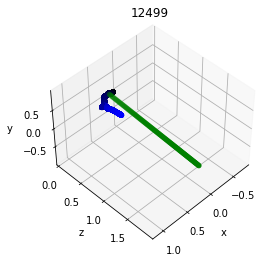

| eval  | E: 249 | S: 12499 | R: 41.8564
| train | E: 250 | S: 12499 | R: 41.0031 | D: 29.9 s | BR: 0.5105 | ALOSS: -30.2549 | CLOSS: 16.2905 | TLOSS: -3.3300 | TVAL: 0.0419 | AENT: -4.0000
| train | E: 251 | S: 12549 | R: 31.6109 | D: 63.4 s | BR: 0.5137 | ALOSS: -30.0395 | CLOSS: 16.2083 | TLOSS: -3.9411 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 252 | S: 12599 | R: 30.0435 | D: 31.7 s | BR: 0.5146 | ALOSS: -30.2073 | CLOSS: 15.0656 | TLOSS: -3.7946 | TVAL: 0.0409 | AENT: -4.0000
| train | E: 253 | S: 12649 | R: 45.9518 | D: 29.9 s | BR: 0.5184 | ALOSS: -30.3320 | CLOSS: 14.6994 | TLOSS: -2.3778 | TVAL: 0.0405 | AENT: -4.0000
| train | E: 254 | S: 12699 | R: 37.2265 | D: 31.7 s | BR: 0.5146 | ALOSS: -30.2639 | CLOSS: 15.0421 | TLOSS: -3.1456 | TVAL: 0.0402 | AENT: -4.0000
| train | E: 255 | S: 12749 | R: 32.8059 | D: 29.8 s | BR: 0.5179 | ALOSS: -30.1850 | CLOSS: 14.2624 | TLOSS: -3.6496 | TVAL: 0.0397 | AENT: -4.0000
| train | E: 256 | S: 12799 | R: 46.0863 | D: 32.5 s | BR: 0.5231

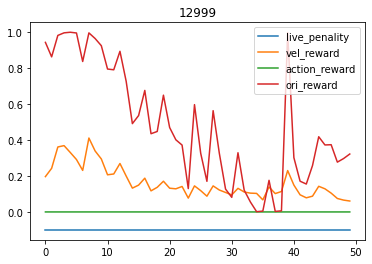

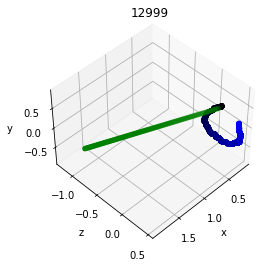

| eval  | E: 259 | S: 12999 | R: 27.3692
| train | E: 260 | S: 12999 | R: 43.1120 | D: 32.4 s | BR: 0.5218 | ALOSS: -30.1273 | CLOSS: 18.7501 | TLOSS: -2.2737 | TVAL: 0.0379 | AENT: -4.0000
| train | E: 261 | S: 13049 | R: 29.0715 | D: 62.2 s | BR: 0.5113 | ALOSS: -30.1412 | CLOSS: 15.7722 | TLOSS: -2.3802 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 262 | S: 13099 | R: 42.4406 | D: 29.6 s | BR: 0.5171 | ALOSS: -29.8977 | CLOSS: 19.0607 | TLOSS: -2.1126 | TVAL: 0.0373 | AENT: -4.0000
| train | E: 263 | S: 13149 | R: 48.8287 | D: 31.9 s | BR: 0.5248 | ALOSS: -30.1867 | CLOSS: 13.9040 | TLOSS: -1.2685 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 264 | S: 13199 | R: 31.1775 | D: 29.3 s | BR: 0.5119 | ALOSS: -30.1629 | CLOSS: 14.7702 | TLOSS: -1.1422 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 265 | S: 13249 | R: 23.2079 | D: 29.4 s | BR: 0.5217 | ALOSS: -30.0683 | CLOSS: 16.7317 | TLOSS: -0.6104 | TVAL: 0.0368 | AENT: -4.0000
| train | E: 266 | S: 13299 | R: 35.1566 | D: 29.6 s | BR: 0.5396

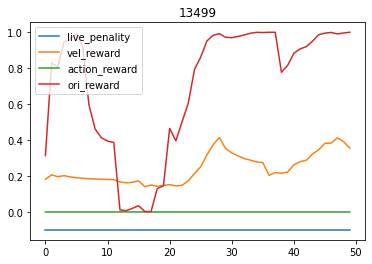

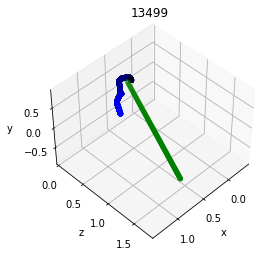

| eval  | E: 269 | S: 13499 | R: 42.1578
| train | E: 270 | S: 13499 | R: 50.1690 | D: 29.8 s | BR: 0.5332 | ALOSS: -29.9770 | CLOSS: 16.2043 | TLOSS: -1.4653 | TVAL: 0.0353 | AENT: -4.0000
| train | E: 271 | S: 13549 | R: 39.9540 | D: 58.3 s | BR: 0.5219 | ALOSS: -29.9947 | CLOSS: 16.0108 | TLOSS: -1.2710 | TVAL: 0.0352 | AENT: -4.0000
| train | E: 272 | S: 13599 | R: 42.8343 | D: 29.9 s | BR: 0.5289 | ALOSS: -30.1282 | CLOSS: 12.4956 | TLOSS: -2.2915 | TVAL: 0.0349 | AENT: -4.0000
| train | E: 273 | S: 13649 | R: 49.8713 | D: 31.0 s | BR: 0.5414 | ALOSS: -30.1674 | CLOSS: 13.9155 | TLOSS: -2.1328 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 274 | S: 13699 | R: 43.4229 | D: 29.3 s | BR: 0.5412 | ALOSS: -30.1691 | CLOSS: 16.3394 | TLOSS: -1.0855 | TVAL: 0.0343 | AENT: -4.0000
| train | E: 275 | S: 13749 | R: 45.4920 | D: 29.4 s | BR: 0.5331 | ALOSS: -30.0971 | CLOSS: 13.5719 | TLOSS: -1.4608 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 276 | S: 13799 | R: 29.2619 | D: 29.5 s | BR: 0.5287

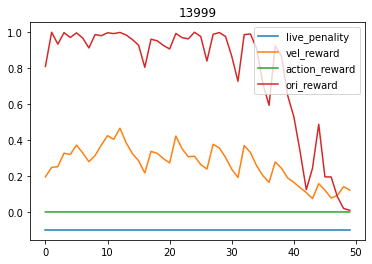

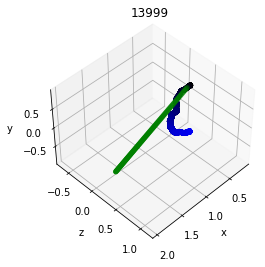

| eval  | E: 279 | S: 13999 | R: 47.4589
| train | E: 280 | S: 13999 | R: 43.5398 | D: 29.4 s | BR: 0.5297 | ALOSS: -30.0580 | CLOSS: 15.1995 | TLOSS: -1.1944 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 281 | S: 14049 | R: 38.9971 | D: 59.1 s | BR: 0.5481 | ALOSS: -30.1524 | CLOSS: 14.5664 | TLOSS: -1.5664 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 282 | S: 14099 | R: 47.3302 | D: 29.6 s | BR: 0.5416 | ALOSS: -30.1184 | CLOSS: 15.0033 | TLOSS: -1.3824 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 283 | S: 14149 | R: 19.7604 | D: 31.9 s | BR: 0.5487 | ALOSS: -30.1634 | CLOSS: 14.0001 | TLOSS: -1.4559 | TVAL: 0.0329 | AENT: -4.0000
| train | E: 284 | S: 14199 | R: 52.3608 | D: 31.5 s | BR: 0.5390 | ALOSS: -30.1324 | CLOSS: 12.7575 | TLOSS: -1.4317 | TVAL: 0.0327 | AENT: -4.0000
| train | E: 285 | S: 14249 | R: 35.5609 | D: 33.5 s | BR: 0.5387 | ALOSS: -30.0990 | CLOSS: 14.4624 | TLOSS: -1.3280 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 286 | S: 14299 | R: 42.9306 | D: 30.1 s | BR: 0.5467

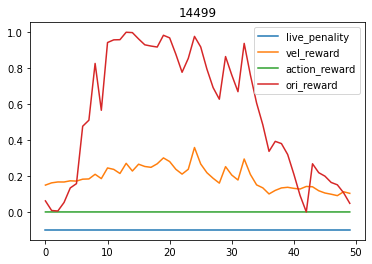

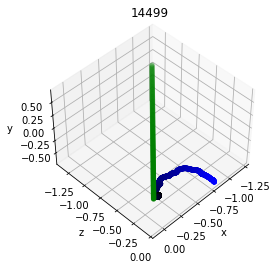

| eval  | E: 289 | S: 14499 | R: 32.3517
| train | E: 290 | S: 14499 | R: 47.8499 | D: 29.6 s | BR: 0.5447 | ALOSS: -29.9960 | CLOSS: 15.2719 | TLOSS: -0.3068 | TVAL: 0.0315 | AENT: -4.0000
| train | E: 291 | S: 14549 | R: 36.3059 | D: 61.0 s | BR: 0.5606 | ALOSS: -30.1606 | CLOSS: 13.4266 | TLOSS: 0.1351 | TVAL: 0.0315 | AENT: -4.0000
| train | E: 292 | S: 14599 | R: 32.1202 | D: 29.5 s | BR: 0.5519 | ALOSS: -29.9944 | CLOSS: 15.6388 | TLOSS: -1.0460 | TVAL: 0.0315 | AENT: -4.0000
| train | E: 293 | S: 14649 | R: 37.4041 | D: 29.7 s | BR: 0.5522 | ALOSS: -30.1293 | CLOSS: 14.0493 | TLOSS: -1.3077 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 294 | S: 14699 | R: 23.4383 | D: 32.8 s | BR: 0.5459 | ALOSS: -30.1352 | CLOSS: 15.0504 | TLOSS: -0.6927 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 295 | S: 14749 | R: 40.9512 | D: 31.5 s | BR: 0.5503 | ALOSS: -29.9474 | CLOSS: 17.5292 | TLOSS: -0.5994 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 296 | S: 14799 | R: 24.6826 | D: 29.1 s | BR: 0.5581 

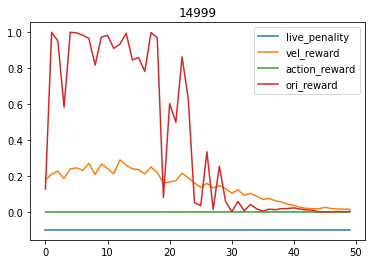

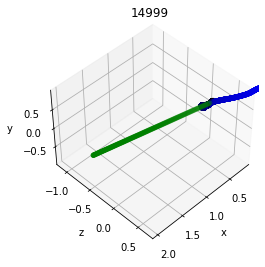

| eval  | E: 299 | S: 14999 | R: 22.5756
| train | E: 300 | S: 14999 | R: 26.4282 | D: 29.6 s | BR: 0.5562 | ALOSS: -30.1352 | CLOSS: 14.2233 | TLOSS: 0.9897 | TVAL: 0.0307 | AENT: -4.0000
| train | E: 301 | S: 15049 | R: 41.2833 | D: 59.0 s | BR: 0.5492 | ALOSS: -29.9810 | CLOSS: 17.8984 | TLOSS: 0.6317 | TVAL: 0.0309 | AENT: -4.0000
| train | E: 302 | S: 15099 | R: 39.6310 | D: 29.2 s | BR: 0.5516 | ALOSS: -30.1277 | CLOSS: 12.8400 | TLOSS: 0.7897 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 303 | S: 15149 | R: 32.4458 | D: 29.6 s | BR: 0.5671 | ALOSS: -30.0561 | CLOSS: 15.1803 | TLOSS: 0.3334 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 304 | S: 15199 | R: 15.7609 | D: 30.2 s | BR: 0.5657 | ALOSS: -30.1146 | CLOSS: 12.1605 | TLOSS: 0.4741 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 305 | S: 15249 | R: 37.4607 | D: 29.2 s | BR: 0.5552 | ALOSS: -30.0972 | CLOSS: 12.9275 | TLOSS: 0.2160 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 306 | S: 15299 | R: 24.1073 | D: 30.8 s | BR: 0.5424 | ALO

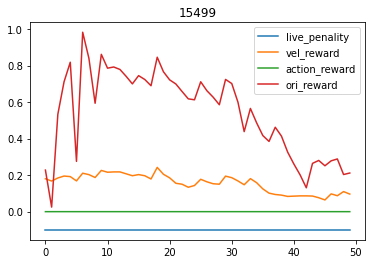

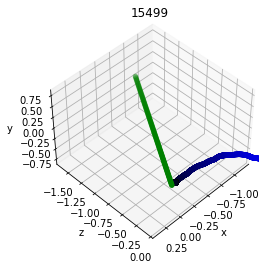

| eval  | E: 309 | S: 15499 | R: 30.0300
| train | E: 310 | S: 15499 | R: 20.3934 | D: 29.6 s | BR: 0.5588 | ALOSS: -29.7958 | CLOSS: 14.0976 | TLOSS: -0.3373 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 311 | S: 15549 | R: 34.5218 | D: 58.5 s | BR: 0.5397 | ALOSS: -30.0030 | CLOSS: 11.2500 | TLOSS: 0.1348 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 312 | S: 15599 | R: 12.9148 | D: 30.4 s | BR: 0.5606 | ALOSS: -29.8903 | CLOSS: 13.7186 | TLOSS: 0.3161 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 313 | S: 15649 | R: 22.3495 | D: 30.7 s | BR: 0.5531 | ALOSS: -29.6841 | CLOSS: 18.4617 | TLOSS: -0.6405 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 314 | S: 15699 | R: 30.6671 | D: 29.8 s | BR: 0.5571 | ALOSS: -29.8086 | CLOSS: 12.8760 | TLOSS: 0.0688 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 315 | S: 15749 | R: 35.6719 | D: 32.4 s | BR: 0.5471 | ALOSS: -29.7522 | CLOSS: 15.3944 | TLOSS: 0.2138 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 316 | S: 15799 | R: 29.4251 | D: 29.6 s | BR: 0.5605 | A

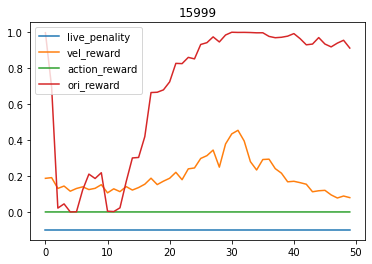

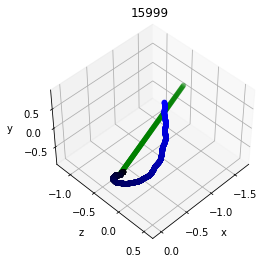

| eval  | E: 319 | S: 15999 | R: 38.6282
| train | E: 320 | S: 15999 | R: 36.1250 | D: 29.9 s | BR: 0.5627 | ALOSS: -29.5953 | CLOSS: 14.5546 | TLOSS: 0.9356 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 321 | S: 16049 | R: 36.0508 | D: 63.3 s | BR: 0.5612 | ALOSS: -29.7943 | CLOSS: 12.1758 | TLOSS: 1.3273 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 322 | S: 16099 | R: 29.3006 | D: 33.6 s | BR: 0.5526 | ALOSS: -29.6550 | CLOSS: 14.1315 | TLOSS: 0.0552 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 323 | S: 16149 | R: 18.7796 | D: 29.6 s | BR: 0.5566 | ALOSS: -29.7844 | CLOSS: 13.9368 | TLOSS: 0.0358 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 324 | S: 16199 | R: 33.4893 | D: 29.9 s | BR: 0.5599 | ALOSS: -29.7818 | CLOSS: 13.3522 | TLOSS: 0.6139 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 325 | S: 16249 | R: 44.8912 | D: 29.7 s | BR: 0.5533 | ALOSS: -29.8126 | CLOSS: 13.2884 | TLOSS: 1.2572 | TVAL: 0.0327 | AENT: -4.0000
| train | E: 326 | S: 16299 | R: 27.8532 | D: 29.7 s | BR: 0.5610 | ALO

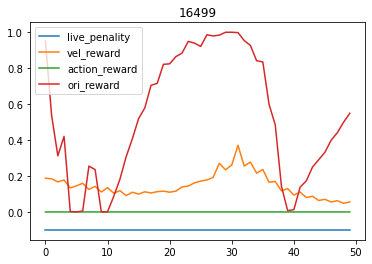

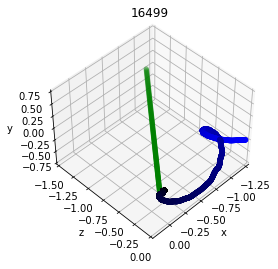

| eval  | E: 329 | S: 16499 | R: 28.5276
| train | E: 330 | S: 16499 | R: 42.4565 | D: 30.4 s | BR: 0.5566 | ALOSS: -29.5332 | CLOSS: 15.7371 | TLOSS: 0.9242 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 331 | S: 16549 | R: 32.2400 | D: 59.9 s | BR: 0.5656 | ALOSS: -29.5212 | CLOSS: 12.6802 | TLOSS: 0.4523 | TVAL: 0.0341 | AENT: -4.0000
| train | E: 332 | S: 16599 | R: 46.5894 | D: 29.3 s | BR: 0.5653 | ALOSS: -29.6898 | CLOSS: 12.7884 | TLOSS: 1.0920 | TVAL: 0.0343 | AENT: -4.0000
| train | E: 333 | S: 16649 | R: 20.8921 | D: 31.8 s | BR: 0.5561 | ALOSS: -29.7318 | CLOSS: 14.0762 | TLOSS: 1.2230 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 334 | S: 16699 | R: 32.5925 | D: 29.3 s | BR: 0.5545 | ALOSS: -29.7307 | CLOSS: 16.0473 | TLOSS: 1.7340 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 335 | S: 16749 | R: 32.7508 | D: 30.5 s | BR: 0.5747 | ALOSS: -29.6102 | CLOSS: 15.8027 | TLOSS: 0.7202 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 336 | S: 16799 | R: 21.1815 | D: 29.8 s | BR: 0.5526 | ALO

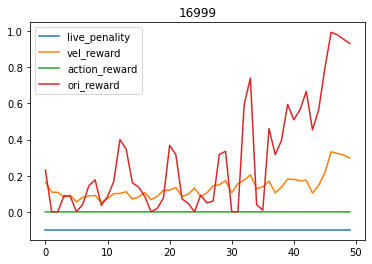

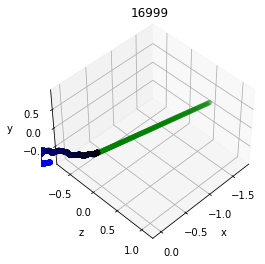

| eval  | E: 339 | S: 16999 | R: 16.3407
| train | E: 340 | S: 16999 | R: 23.7238 | D: 32.9 s | BR: 0.5541 | ALOSS: -29.6228 | CLOSS: 14.1563 | TLOSS: 0.4059 | TVAL: 0.0361 | AENT: -4.0000
| train | E: 341 | S: 17049 | R: 7.6676 | D: 58.9 s | BR: 0.5646 | ALOSS: -29.5397 | CLOSS: 12.9453 | TLOSS: 1.1646 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 342 | S: 17099 | R: 25.3563 | D: 30.0 s | BR: 0.5488 | ALOSS: -29.3506 | CLOSS: 15.3091 | TLOSS: 0.1467 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 343 | S: 17149 | R: 15.6944 | D: 29.1 s | BR: 0.5597 | ALOSS: -29.3988 | CLOSS: 14.3041 | TLOSS: -0.0421 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 344 | S: 17199 | R: 11.7489 | D: 29.6 s | BR: 0.5441 | ALOSS: -29.3938 | CLOSS: 15.0077 | TLOSS: 1.0144 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 345 | S: 17249 | R: 20.3453 | D: 29.9 s | BR: 0.5475 | ALOSS: -29.2289 | CLOSS: 14.9763 | TLOSS: 1.0077 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 346 | S: 17299 | R: 17.8645 | D: 30.4 s | BR: 0.5529 | ALO

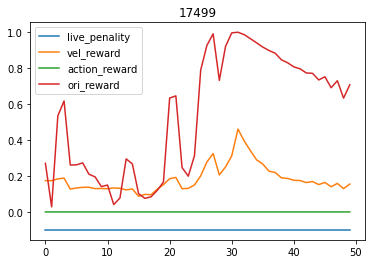

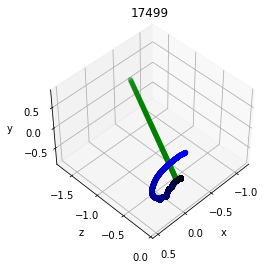

| eval  | E: 349 | S: 17499 | R: 31.4311
| train | E: 350 | S: 17499 | R: 22.6393 | D: 29.2 s | BR: 0.5576 | ALOSS: -29.6248 | CLOSS: 14.2408 | TLOSS: -1.6589 | TVAL: 0.0375 | AENT: -4.0000
| train | E: 351 | S: 17549 | R: 27.7724 | D: 59.0 s | BR: 0.5495 | ALOSS: -29.4026 | CLOSS: 14.9356 | TLOSS: 1.9441 | TVAL: 0.0374 | AENT: -4.0000
| train | E: 352 | S: 17599 | R: 31.7079 | D: 29.4 s | BR: 0.5535 | ALOSS: -29.3193 | CLOSS: 15.5208 | TLOSS: 0.1919 | TVAL: 0.0379 | AENT: -4.0000
| train | E: 353 | S: 17649 | R: 18.7585 | D: 35.8 s | BR: 0.5554 | ALOSS: -29.4833 | CLOSS: 13.7803 | TLOSS: 0.5727 | TVAL: 0.0379 | AENT: -4.0000
| train | E: 354 | S: 17699 | R: 30.2881 | D: 32.1 s | BR: 0.5546 | ALOSS: -29.4084 | CLOSS: 11.5656 | TLOSS: -0.9610 | TVAL: 0.0380 | AENT: -4.0000
| train | E: 355 | S: 17749 | R: 59.2843 | D: 30.3 s | BR: 0.5480 | ALOSS: -29.4272 | CLOSS: 14.6711 | TLOSS: -0.7414 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 356 | S: 17799 | R: 37.9206 | D: 29.3 s | BR: 0.5499 | 

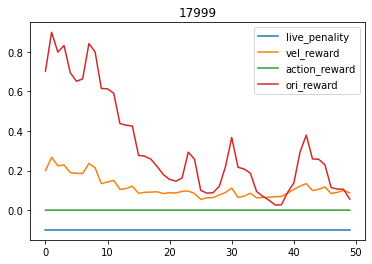

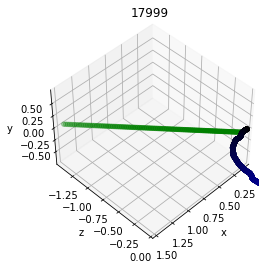

| eval  | E: 359 | S: 17999 | R: 16.7920
| train | E: 360 | S: 17999 | R: 34.6955 | D: 29.3 s | BR: 0.5572 | ALOSS: -29.4258 | CLOSS: 11.6997 | TLOSS: -0.3815 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 361 | S: 18049 | R: 41.5431 | D: 59.2 s | BR: 0.5378 | ALOSS: -29.2256 | CLOSS: 16.7911 | TLOSS: 0.6642 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 362 | S: 18099 | R: 35.0391 | D: 30.1 s | BR: 0.5639 | ALOSS: -29.3836 | CLOSS: 13.3802 | TLOSS: -1.0438 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 363 | S: 18149 | R: 22.7913 | D: 29.2 s | BR: 0.5637 | ALOSS: -29.1754 | CLOSS: 16.9506 | TLOSS: -0.0159 | TVAL: 0.0368 | AENT: -4.0000
| train | E: 364 | S: 18199 | R: 26.8017 | D: 29.5 s | BR: 0.5764 | ALOSS: -29.5355 | CLOSS: 11.8262 | TLOSS: -0.3900 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 365 | S: 18249 | R: 39.6290 | D: 29.3 s | BR: 0.5562 | ALOSS: -29.4272 | CLOSS: 14.0311 | TLOSS: 0.1111 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 366 | S: 18299 | R: 40.3538 | D: 33.6 s | BR: 0.5559 |

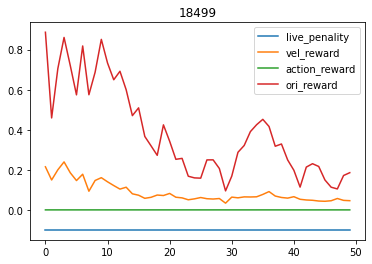

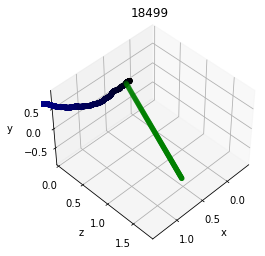

| eval  | E: 369 | S: 18499 | R: 18.7266
| train | E: 370 | S: 18499 | R: 30.2533 | D: 30.1 s | BR: 0.5501 | ALOSS: -29.7275 | CLOSS: 12.8058 | TLOSS: 0.9210 | TVAL: 0.0375 | AENT: -4.0000
| train | E: 371 | S: 18549 | R: 26.7366 | D: 61.0 s | BR: 0.5674 | ALOSS: -29.8277 | CLOSS: 14.2589 | TLOSS: 1.4460 | TVAL: 0.0378 | AENT: -4.0000
| train | E: 372 | S: 18599 | R: 21.3434 | D: 29.9 s | BR: 0.5748 | ALOSS: -29.7188 | CLOSS: 14.1111 | TLOSS: 0.5138 | TVAL: 0.0381 | AENT: -4.0000
| train | E: 373 | S: 18649 | R: 37.6298 | D: 30.1 s | BR: 0.5818 | ALOSS: -29.8723 | CLOSS: 14.2789 | TLOSS: 1.1265 | TVAL: 0.0383 | AENT: -4.0000
| train | E: 374 | S: 18699 | R: 48.7380 | D: 29.7 s | BR: 0.5731 | ALOSS: -29.8574 | CLOSS: 15.8221 | TLOSS: 0.9630 | TVAL: 0.0386 | AENT: -4.0000
| train | E: 375 | S: 18749 | R: 37.1331 | D: 30.9 s | BR: 0.5685 | ALOSS: -29.7891 | CLOSS: 14.8231 | TLOSS: 1.2735 | TVAL: 0.0390 | AENT: -4.0000
| train | E: 376 | S: 18799 | R: 49.5843 | D: 30.7 s | BR: 0.5493 | ALO

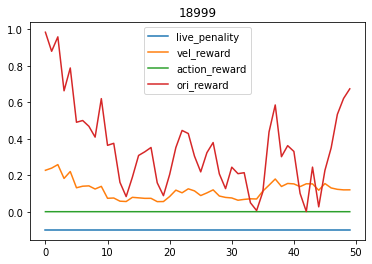

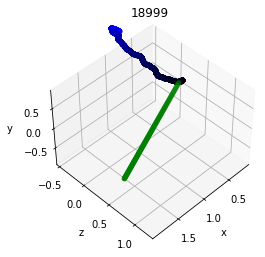

| eval  | E: 379 | S: 18999 | R: 18.7099
| train | E: 380 | S: 18999 | R: 13.9157 | D: 30.0 s | BR: 0.5653 | ALOSS: -29.8064 | CLOSS: 15.1066 | TLOSS: 2.0893 | TVAL: 0.0403 | AENT: -4.0000
| train | E: 381 | S: 19049 | R: 12.1956 | D: 62.4 s | BR: 0.5644 | ALOSS: -29.7341 | CLOSS: 14.2862 | TLOSS: 1.6703 | TVAL: 0.0409 | AENT: -4.0000
| train | E: 382 | S: 19099 | R: 31.7591 | D: 34.3 s | BR: 0.5819 | ALOSS: -30.1301 | CLOSS: 12.2237 | TLOSS: 0.7921 | TVAL: 0.0413 | AENT: -4.0000
| train | E: 383 | S: 19149 | R: 11.0001 | D: 29.3 s | BR: 0.5564 | ALOSS: -29.6622 | CLOSS: 17.4064 | TLOSS: -0.5624 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 384 | S: 19199 | R: 19.1459 | D: 30.1 s | BR: 0.5673 | ALOSS: -29.8392 | CLOSS: 11.5844 | TLOSS: -1.3126 | TVAL: 0.0412 | AENT: -4.0000
| train | E: 385 | S: 19249 | R: 42.5401 | D: 29.0 s | BR: 0.5757 | ALOSS: -30.1062 | CLOSS: 13.6996 | TLOSS: -0.5867 | TVAL: 0.0409 | AENT: -4.0000
| train | E: 386 | S: 19299 | R: 18.3161 | D: 29.4 s | BR: 0.5670 | 

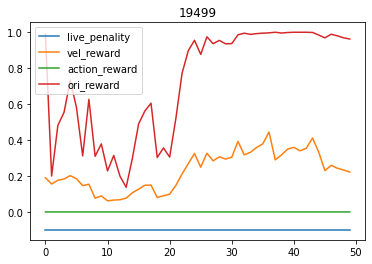

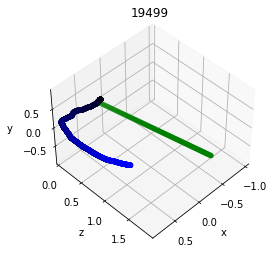

| eval  | E: 389 | S: 19499 | R: 43.0383
| train | E: 390 | S: 19499 | R: 18.8190 | D: 30.1 s | BR: 0.5529 | ALOSS: -29.8304 | CLOSS: 14.4173 | TLOSS: -1.1671 | TVAL: 0.0400 | AENT: -4.0000
| train | E: 391 | S: 19549 | R: 24.9064 | D: 62.1 s | BR: 0.5586 | ALOSS: -29.8349 | CLOSS: 14.1664 | TLOSS: -0.5328 | TVAL: 0.0397 | AENT: -4.0000
| train | E: 392 | S: 19599 | R: 18.4339 | D: 31.4 s | BR: 0.5510 | ALOSS: -29.6965 | CLOSS: 17.3428 | TLOSS: -1.0485 | TVAL: 0.0395 | AENT: -4.0000
| train | E: 393 | S: 19649 | R: 27.7874 | D: 30.3 s | BR: 0.5774 | ALOSS: -30.0188 | CLOSS: 9.7204 | TLOSS: 0.4538 | TVAL: 0.0393 | AENT: -4.0000
| train | E: 394 | S: 19699 | R: 38.2810 | D: 32.2 s | BR: 0.5560 | ALOSS: -29.7505 | CLOSS: 17.7934 | TLOSS: 0.0861 | TVAL: 0.0394 | AENT: -4.0000
| train | E: 395 | S: 19749 | R: 42.2552 | D: 30.3 s | BR: 0.5593 | ALOSS: -29.6923 | CLOSS: 16.4507 | TLOSS: -0.8124 | TVAL: 0.0394 | AENT: -4.0000
| train | E: 396 | S: 19799 | R: 45.8531 | D: 31.9 s | BR: 0.5523 | 

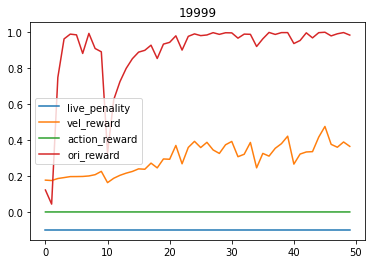

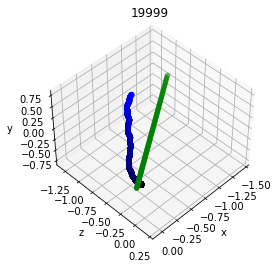

| eval  | E: 399 | S: 19999 | R: 54.5129
| train | E: 400 | S: 19999 | R: 41.7289 | D: 30.6 s | BR: 0.5611 | ALOSS: -29.8173 | CLOSS: 16.3206 | TLOSS: -0.3546 | TVAL: 0.0391 | AENT: -4.0000
| train | E: 401 | S: 20049 | R: 44.8478 | D: 59.2 s | BR: 0.5619 | ALOSS: -29.7736 | CLOSS: 16.6835 | TLOSS: -0.4594 | TVAL: 0.0390 | AENT: -4.0000
| train | E: 402 | S: 20099 | R: 46.3265 | D: 29.8 s | BR: 0.5575 | ALOSS: -29.8497 | CLOSS: 15.7057 | TLOSS: 0.0887 | TVAL: 0.0389 | AENT: -4.0000
| train | E: 403 | S: 20149 | R: 36.5007 | D: 29.7 s | BR: 0.5623 | ALOSS: -29.7999 | CLOSS: 17.4140 | TLOSS: 0.7054 | TVAL: 0.0390 | AENT: -4.0000
| train | E: 404 | S: 20199 | R: 44.5085 | D: 30.2 s | BR: 0.5803 | ALOSS: -30.1269 | CLOSS: 16.3722 | TLOSS: 0.9080 | TVAL: 0.0392 | AENT: -4.0000
| train | E: 405 | S: 20249 | R: 48.2225 | D: 32.3 s | BR: 0.5553 | ALOSS: -29.8776 | CLOSS: 16.7306 | TLOSS: 0.9763 | TVAL: 0.0395 | AENT: -4.0000
| train | E: 406 | S: 20299 | R: 35.2497 | D: 29.9 s | BR: 0.5576 | A

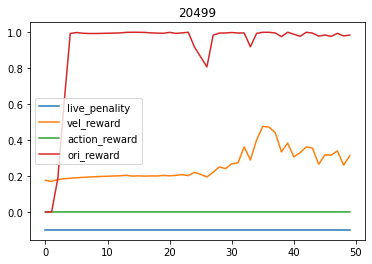

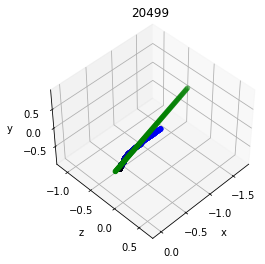

| eval  | E: 409 | S: 20499 | R: 53.9026
| train | E: 410 | S: 20499 | R: 50.5081 | D: 29.5 s | BR: 0.5729 | ALOSS: -30.1863 | CLOSS: 14.3265 | TLOSS: 0.2974 | TVAL: 0.0409 | AENT: -4.0000
| train | E: 411 | S: 20549 | R: 53.1136 | D: 59.4 s | BR: 0.5671 | ALOSS: -30.0227 | CLOSS: 15.5191 | TLOSS: 1.1715 | TVAL: 0.0411 | AENT: -4.0000
| train | E: 412 | S: 20599 | R: 45.1979 | D: 29.8 s | BR: 0.5769 | ALOSS: -30.2004 | CLOSS: 15.2253 | TLOSS: 0.4648 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 413 | S: 20649 | R: 54.7087 | D: 30.2 s | BR: 0.5947 | ALOSS: -30.1266 | CLOSS: 16.2860 | TLOSS: -0.0788 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 414 | S: 20699 | R: 57.7435 | D: 29.8 s | BR: 0.5774 | ALOSS: -30.2109 | CLOSS: 14.4311 | TLOSS: -0.4978 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 415 | S: 20749 | R: 53.4274 | D: 29.3 s | BR: 0.5842 | ALOSS: -30.0819 | CLOSS: 14.9013 | TLOSS: -0.7802 | TVAL: 0.0413 | AENT: -4.0000
| train | E: 416 | S: 20799 | R: 52.3863 | D: 29.3 s | BR: 0.5821 | 

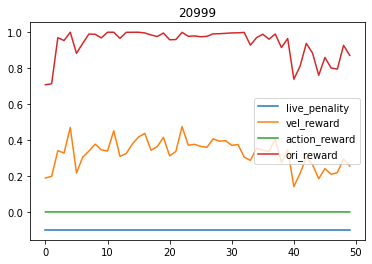

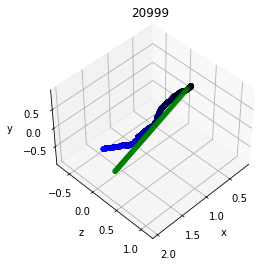

| eval  | E: 419 | S: 20999 | R: 58.3376
| train | E: 420 | S: 20999 | R: 51.9584 | D: 29.4 s | BR: 0.6007 | ALOSS: -30.6650 | CLOSS: 16.3316 | TLOSS: -0.0410 | TVAL: 0.0411 | AENT: -4.0000
| train | E: 421 | S: 21049 | R: 56.0221 | D: 62.3 s | BR: 0.5925 | ALOSS: -30.7257 | CLOSS: 15.1571 | TLOSS: 0.4285 | TVAL: 0.0411 | AENT: -4.0000
| train | E: 422 | S: 21099 | R: 54.9246 | D: 30.2 s | BR: 0.5884 | ALOSS: -30.6760 | CLOSS: 14.2873 | TLOSS: 0.1694 | TVAL: 0.0413 | AENT: -4.0000
| train | E: 423 | S: 21149 | R: 53.5570 | D: 29.9 s | BR: 0.5823 | ALOSS: -30.6611 | CLOSS: 12.7431 | TLOSS: 0.4302 | TVAL: 0.0414 | AENT: -4.0000
| train | E: 424 | S: 21199 | R: 56.7423 | D: 29.9 s | BR: 0.5961 | ALOSS: -30.6637 | CLOSS: 16.3703 | TLOSS: 0.1028 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 425 | S: 21249 | R: 52.4830 | D: 29.0 s | BR: 0.5818 | ALOSS: -30.7098 | CLOSS: 12.6677 | TLOSS: 0.8231 | TVAL: 0.0417 | AENT: -4.0000
| train | E: 426 | S: 21299 | R: 62.0082 | D: 29.6 s | BR: 0.6025 | AL

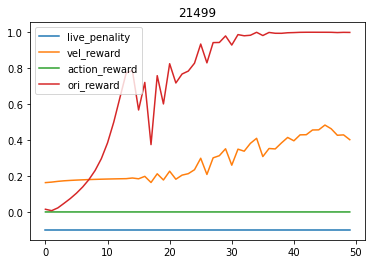

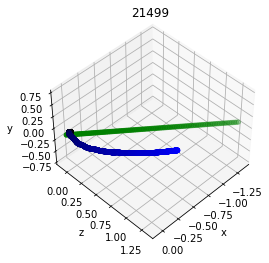

| eval  | E: 429 | S: 21499 | R: 44.6727
| train | E: 430 | S: 21499 | R: 54.3372 | D: 29.2 s | BR: 0.6034 | ALOSS: -30.9586 | CLOSS: 16.7221 | TLOSS: 0.5010 | TVAL: 0.0422 | AENT: -4.0000
| train | E: 431 | S: 21549 | R: 44.6131 | D: 59.3 s | BR: 0.6007 | ALOSS: -30.9030 | CLOSS: 17.8714 | TLOSS: -0.0972 | TVAL: 0.0423 | AENT: -4.0000
| train | E: 432 | S: 21599 | R: 60.1857 | D: 29.3 s | BR: 0.5928 | ALOSS: -30.8722 | CLOSS: 20.1015 | TLOSS: 0.2044 | TVAL: 0.0423 | AENT: -4.0000
| train | E: 433 | S: 21649 | R: 61.3355 | D: 30.0 s | BR: 0.6005 | ALOSS: -31.0225 | CLOSS: 13.9217 | TLOSS: 0.7804 | TVAL: 0.0425 | AENT: -4.0000
| train | E: 434 | S: 21699 | R: 62.8488 | D: 29.3 s | BR: 0.5973 | ALOSS: -31.3091 | CLOSS: 15.2328 | TLOSS: 0.8112 | TVAL: 0.0428 | AENT: -4.0000
| train | E: 435 | S: 21749 | R: 51.2927 | D: 29.7 s | BR: 0.6036 | ALOSS: -31.0700 | CLOSS: 17.8151 | TLOSS: 0.6809 | TVAL: 0.0431 | AENT: -4.0000
| train | E: 436 | S: 21799 | R: 51.6061 | D: 29.1 s | BR: 0.6098 | AL

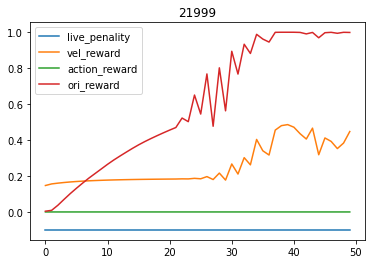

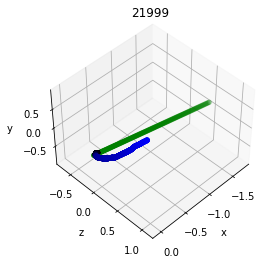

| eval  | E: 439 | S: 21999 | R: 37.7670
| train | E: 440 | S: 21999 | R: 60.5394 | D: 30.3 s | BR: 0.6170 | ALOSS: -31.4649 | CLOSS: 13.2216 | TLOSS: 0.6617 | TVAL: 0.0440 | AENT: -4.0000
| train | E: 441 | S: 22049 | R: 60.5805 | D: 58.9 s | BR: 0.6131 | ALOSS: -31.3026 | CLOSS: 18.4286 | TLOSS: 0.4915 | TVAL: 0.0443 | AENT: -4.0000
| train | E: 442 | S: 22099 | R: 46.9751 | D: 29.3 s | BR: 0.6180 | ALOSS: -31.5059 | CLOSS: 19.2451 | TLOSS: -0.4489 | TVAL: 0.0443 | AENT: -4.0000
| train | E: 443 | S: 22149 | R: 52.2410 | D: 30.4 s | BR: 0.6068 | ALOSS: -31.6706 | CLOSS: 13.6753 | TLOSS: -0.1605 | TVAL: 0.0441 | AENT: -4.0000
| train | E: 444 | S: 22199 | R: 62.7112 | D: 31.3 s | BR: 0.6149 | ALOSS: -31.3443 | CLOSS: 17.3188 | TLOSS: -0.4083 | TVAL: 0.0441 | AENT: -4.0000
| train | E: 445 | S: 22249 | R: 48.4091 | D: 32.2 s | BR: 0.6073 | ALOSS: -31.6470 | CLOSS: 13.7838 | TLOSS: 0.8102 | TVAL: 0.0441 | AENT: -4.0000
| train | E: 446 | S: 22299 | R: 61.4727 | D: 31.8 s | BR: 0.6147 | 

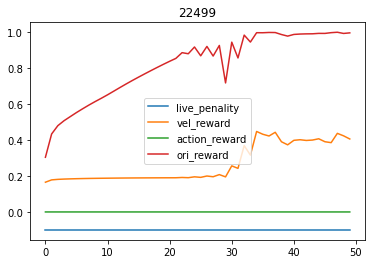

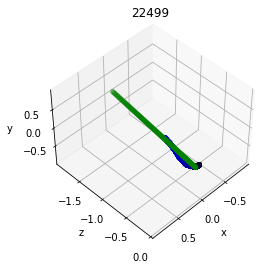

| eval  | E: 449 | S: 22499 | R: 49.3181
| train | E: 450 | S: 22499 | R: 55.6863 | D: 32.0 s | BR: 0.6202 | ALOSS: -31.7247 | CLOSS: 14.2319 | TLOSS: -1.1982 | TVAL: 0.0447 | AENT: -4.0000
| train | E: 451 | S: 22549 | R: 54.3785 | D: 60.4 s | BR: 0.6279 | ALOSS: -31.7832 | CLOSS: 18.3897 | TLOSS: -0.4500 | TVAL: 0.0443 | AENT: -4.0000
| train | E: 452 | S: 22599 | R: 59.8009 | D: 29.5 s | BR: 0.6294 | ALOSS: -32.0250 | CLOSS: 16.8530 | TLOSS: 0.2402 | TVAL: 0.0442 | AENT: -4.0000
| train | E: 453 | S: 22649 | R: 60.1160 | D: 29.6 s | BR: 0.6173 | ALOSS: -31.8019 | CLOSS: 17.9123 | TLOSS: 0.3212 | TVAL: 0.0444 | AENT: -4.0000
| train | E: 454 | S: 22699 | R: 49.8142 | D: 29.4 s | BR: 0.6267 | ALOSS: -31.8456 | CLOSS: 15.0640 | TLOSS: -0.8596 | TVAL: 0.0443 | AENT: -4.0000
| train | E: 455 | S: 22749 | R: 52.7806 | D: 32.3 s | BR: 0.6279 | ALOSS: -32.0956 | CLOSS: 16.4823 | TLOSS: -0.7286 | TVAL: 0.0439 | AENT: -4.0000
| train | E: 456 | S: 22799 | R: 50.5292 | D: 29.2 s | BR: 0.6375 |

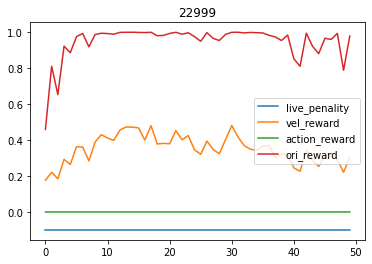

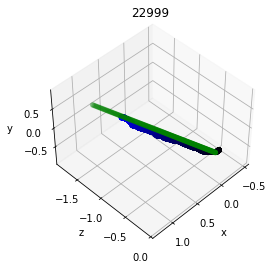

| eval  | E: 459 | S: 22999 | R: 59.9091
| train | E: 460 | S: 22999 | R: 53.9506 | D: 31.5 s | BR: 0.6290 | ALOSS: -32.3906 | CLOSS: 15.7155 | TLOSS: 0.8207 | TVAL: 0.0456 | AENT: -4.0000
| train | E: 461 | S: 23049 | R: 49.8920 | D: 59.2 s | BR: 0.6403 | ALOSS: -32.6809 | CLOSS: 13.4757 | TLOSS: 0.1157 | TVAL: 0.0458 | AENT: -4.0000
| train | E: 462 | S: 23099 | R: 60.2703 | D: 29.2 s | BR: 0.6405 | ALOSS: -32.5493 | CLOSS: 17.5968 | TLOSS: 0.2227 | TVAL: 0.0459 | AENT: -4.0000
| train | E: 463 | S: 23149 | R: 59.8720 | D: 29.5 s | BR: 0.6319 | ALOSS: -32.4986 | CLOSS: 18.8874 | TLOSS: 0.0742 | TVAL: 0.0460 | AENT: -4.0000
| train | E: 464 | S: 23199 | R: 53.3223 | D: 30.4 s | BR: 0.6266 | ALOSS: -32.5442 | CLOSS: 18.5822 | TLOSS: 0.2052 | TVAL: 0.0460 | AENT: -4.0000
| train | E: 465 | S: 23249 | R: 25.5217 | D: 36.7 s | BR: 0.6405 | ALOSS: -32.8277 | CLOSS: 15.8383 | TLOSS: 0.7017 | TVAL: 0.0461 | AENT: -4.0000
| train | E: 466 | S: 23299 | R: 54.8623 | D: 40.5 s | BR: 0.6390 | ALO

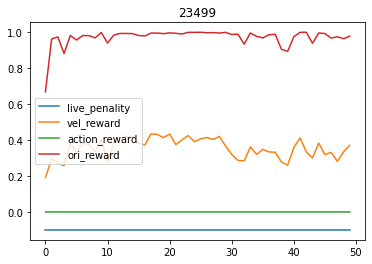

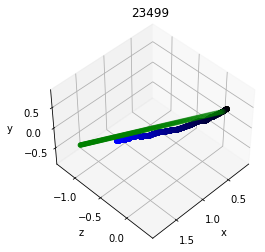

| eval  | E: 469 | S: 23499 | R: 61.3397
| train | E: 470 | S: 23499 | R: 55.5755 | D: 38.6 s | BR: 0.6402 | ALOSS: -32.6794 | CLOSS: 21.5038 | TLOSS: 0.1504 | TVAL: 0.0468 | AENT: -4.0000
| train | E: 471 | S: 23549 | R: 58.2036 | D: 82.4 s | BR: 0.6359 | ALOSS: -32.8238 | CLOSS: 17.3142 | TLOSS: 0.1641 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 472 | S: 23599 | R: 58.4639 | D: 42.2 s | BR: 0.6422 | ALOSS: -32.9316 | CLOSS: 14.3028 | TLOSS: 0.1889 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 473 | S: 23649 | R: 60.4483 | D: 38.0 s | BR: 0.6325 | ALOSS: -33.0725 | CLOSS: 16.0500 | TLOSS: 0.3792 | TVAL: 0.0471 | AENT: -4.0000
| train | E: 474 | S: 23699 | R: 56.4388 | D: 38.4 s | BR: 0.6221 | ALOSS: -32.6331 | CLOSS: 21.5674 | TLOSS: -0.8570 | TVAL: 0.0471 | AENT: -4.0000
| train | E: 475 | S: 23749 | R: 55.0332 | D: 41.2 s | BR: 0.6465 | ALOSS: -32.8763 | CLOSS: 22.9182 | TLOSS: -0.5459 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 476 | S: 23799 | R: 59.5890 | D: 41.5 s | BR: 0.6594 | A

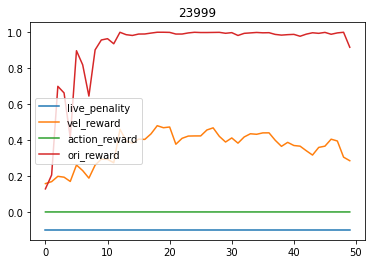

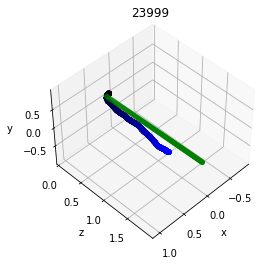

| eval  | E: 479 | S: 23999 | R: 58.9016
| train | E: 480 | S: 23999 | R: 55.4865 | D: 42.2 s | BR: 0.6335 | ALOSS: -33.4004 | CLOSS: 17.9822 | TLOSS: 0.4001 | TVAL: 0.0476 | AENT: -4.0000
| train | E: 481 | S: 24049 | R: 48.2582 | D: 78.8 s | BR: 0.6500 | ALOSS: -33.2895 | CLOSS: 18.5142 | TLOSS: 0.6654 | TVAL: 0.0478 | AENT: -4.0000
| train | E: 482 | S: 24099 | R: 60.9336 | D: 38.9 s | BR: 0.6378 | ALOSS: -33.0121 | CLOSS: 23.8185 | TLOSS: 0.0953 | TVAL: 0.0481 | AENT: -4.0000
| train | E: 483 | S: 24149 | R: 51.6035 | D: 38.3 s | BR: 0.6529 | ALOSS: -33.4588 | CLOSS: 17.5630 | TLOSS: 0.6854 | TVAL: 0.0482 | AENT: -4.0000
| train | E: 484 | S: 24199 | R: 52.0994 | D: 41.3 s | BR: 0.6503 | ALOSS: -33.6438 | CLOSS: 17.4844 | TLOSS: 0.4270 | TVAL: 0.0485 | AENT: -4.0000
| train | E: 485 | S: 24249 | R: 54.2271 | D: 45.1 s | BR: 0.6495 | ALOSS: -33.6897 | CLOSS: 18.0968 | TLOSS: 0.7186 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 486 | S: 24299 | R: 60.8979 | D: 37.1 s | BR: 0.6445 | ALO

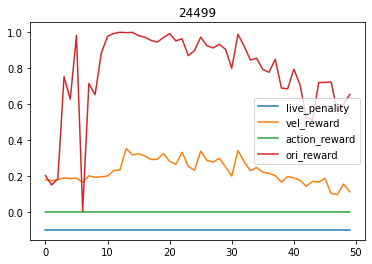

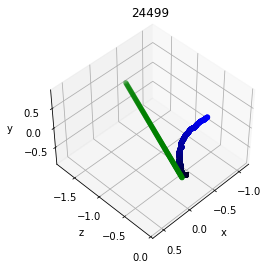

| eval  | E: 489 | S: 24499 | R: 45.3276
| train | E: 490 | S: 24499 | R: 55.0989 | D: 40.7 s | BR: 0.6667 | ALOSS: -33.7669 | CLOSS: 21.7419 | TLOSS: -0.0459 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 491 | S: 24549 | R: 51.0658 | D: 75.5 s | BR: 0.6512 | ALOSS: -33.6337 | CLOSS: 20.2728 | TLOSS: 0.1243 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 492 | S: 24599 | R: 50.1377 | D: 38.9 s | BR: 0.6573 | ALOSS: -33.8815 | CLOSS: 19.1149 | TLOSS: 0.1336 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 493 | S: 24649 | R: 54.4099 | D: 38.3 s | BR: 0.6467 | ALOSS: -33.7053 | CLOSS: 19.8718 | TLOSS: 0.7305 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 494 | S: 24699 | R: 56.4988 | D: 38.7 s | BR: 0.6708 | ALOSS: -34.1195 | CLOSS: 19.7580 | TLOSS: -0.0118 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 495 | S: 24749 | R: 55.9264 | D: 37.5 s | BR: 0.6672 | ALOSS: -34.4622 | CLOSS: 15.4896 | TLOSS: -0.5908 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 496 | S: 24799 | R: 54.8782 | D: 38.6 s | BR: 0.6575 | 

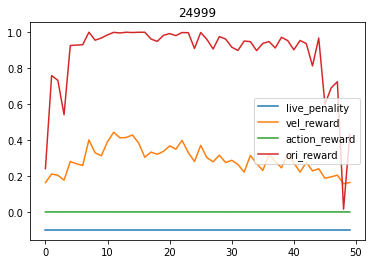

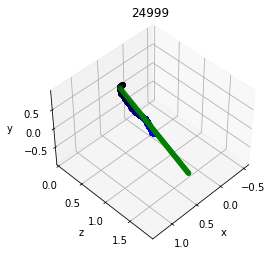

| eval  | E: 499 | S: 24999 | R: 53.4552
| train | E: 500 | S: 24999 | R: 50.6476 | D: 35.3 s | BR: 0.6671 | ALOSS: -34.3060 | CLOSS: 18.5064 | TLOSS: -0.9945 | TVAL: 0.0508 | AENT: -4.0000
| train | E: 501 | S: 25049 | R: 51.1924 | D: 77.1 s | BR: 0.6654 | ALOSS: -34.2991 | CLOSS: 17.3650 | TLOSS: 0.0982 | TVAL: 0.0505 | AENT: -4.0000
| train | E: 502 | S: 25099 | R: 59.0243 | D: 39.4 s | BR: 0.6714 | ALOSS: -34.3566 | CLOSS: 20.2495 | TLOSS: -0.2379 | TVAL: 0.0504 | AENT: -4.0000
| train | E: 503 | S: 25149 | R: 51.5338 | D: 41.6 s | BR: 0.6662 | ALOSS: -34.3296 | CLOSS: 19.5772 | TLOSS: 0.0661 | TVAL: 0.0504 | AENT: -4.0000
| train | E: 504 | S: 25199 | R: 57.6909 | D: 42.3 s | BR: 0.6618 | ALOSS: -34.3720 | CLOSS: 17.4906 | TLOSS: 0.3803 | TVAL: 0.0505 | AENT: -4.0000
| train | E: 505 | S: 25249 | R: 61.0024 | D: 45.8 s | BR: 0.6797 | ALOSS: -34.2390 | CLOSS: 22.8114 | TLOSS: -0.2340 | TVAL: 0.0505 | AENT: -4.0000
| train | E: 506 | S: 25299 | R: 45.2149 | D: 44.7 s | BR: 0.6726 | 

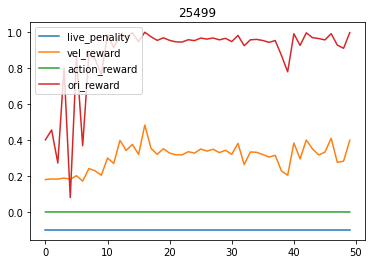

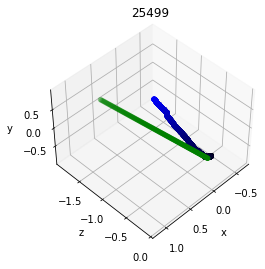

| eval  | E: 509 | S: 25499 | R: 54.1872
| train | E: 510 | S: 25499 | R: 43.4028 | D: 39.1 s | BR: 0.6581 | ALOSS: -34.2902 | CLOSS: 18.5171 | TLOSS: 0.0491 | TVAL: 0.0495 | AENT: -4.0000
| train | E: 511 | S: 25549 | R: 54.1584 | D: 77.1 s | BR: 0.6719 | ALOSS: -34.6817 | CLOSS: 19.1405 | TLOSS: -0.0100 | TVAL: 0.0496 | AENT: -4.0000
| train | E: 512 | S: 25599 | R: 54.2699 | D: 38.3 s | BR: 0.6796 | ALOSS: -34.3303 | CLOSS: 25.7266 | TLOSS: -0.2697 | TVAL: 0.0495 | AENT: -4.0000
| train | E: 513 | S: 25649 | R: 52.3532 | D: 39.1 s | BR: 0.6760 | ALOSS: -34.3855 | CLOSS: 20.5455 | TLOSS: -0.1515 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 514 | S: 25699 | R: 51.4249 | D: 36.9 s | BR: 0.6890 | ALOSS: -34.8162 | CLOSS: 24.0349 | TLOSS: 0.0228 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 515 | S: 25749 | R: 49.5481 | D: 39.0 s | BR: 0.6752 | ALOSS: -34.5498 | CLOSS: 19.4994 | TLOSS: 0.6574 | TVAL: 0.0495 | AENT: -4.0000
| train | E: 516 | S: 25799 | R: 49.3005 | D: 37.5 s | BR: 0.6784 | 

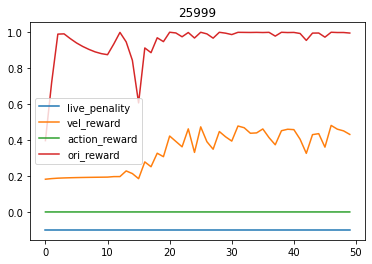

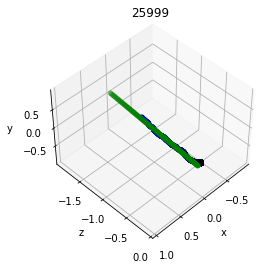

| eval  | E: 519 | S: 25999 | R: 59.2158
| train | E: 520 | S: 25999 | R: 60.2295 | D: 38.4 s | BR: 0.6920 | ALOSS: -34.6837 | CLOSS: 21.3253 | TLOSS: -0.5683 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 521 | S: 26049 | R: 41.7383 | D: 78.4 s | BR: 0.6750 | ALOSS: -34.6432 | CLOSS: 21.0944 | TLOSS: 0.0743 | TVAL: 0.0498 | AENT: -4.0000
| train | E: 522 | S: 26099 | R: 59.7739 | D: 39.1 s | BR: 0.6736 | ALOSS: -34.7022 | CLOSS: 20.0930 | TLOSS: -0.2829 | TVAL: 0.0498 | AENT: -4.0000
| train | E: 523 | S: 26149 | R: 54.6748 | D: 39.8 s | BR: 0.6771 | ALOSS: -34.9524 | CLOSS: 18.1907 | TLOSS: 0.0753 | TVAL: 0.0497 | AENT: -4.0000
| train | E: 524 | S: 26199 | R: 56.5270 | D: 37.8 s | BR: 0.6825 | ALOSS: -34.9125 | CLOSS: 14.6839 | TLOSS: 0.3182 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 525 | S: 26249 | R: 57.1869 | D: 40.6 s | BR: 0.6826 | ALOSS: -35.1267 | CLOSS: 16.5018 | TLOSS: 0.1279 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 526 | S: 26299 | R: 60.5977 | D: 37.7 s | BR: 0.6882 | A

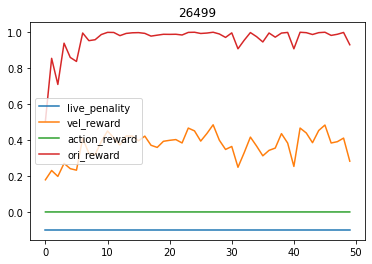

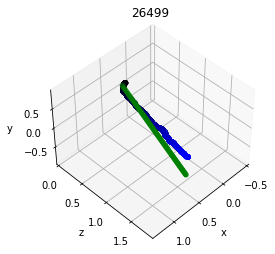

| eval  | E: 529 | S: 26499 | R: 61.4375
| train | E: 530 | S: 26499 | R: 53.6023 | D: 39.4 s | BR: 0.6738 | ALOSS: -35.1447 | CLOSS: 20.0384 | TLOSS: -0.3798 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 531 | S: 26549 | R: 59.8022 | D: 76.5 s | BR: 0.6856 | ALOSS: -35.5321 | CLOSS: 18.9955 | TLOSS: 0.0888 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 532 | S: 26599 | R: 46.6057 | D: 39.3 s | BR: 0.6812 | ALOSS: -35.1967 | CLOSS: 19.3311 | TLOSS: 0.2987 | TVAL: 0.0500 | AENT: -4.0000
| train | E: 533 | S: 26649 | R: 59.4719 | D: 42.5 s | BR: 0.6946 | ALOSS: -35.3149 | CLOSS: 21.5525 | TLOSS: -0.0281 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 534 | S: 26699 | R: 61.9039 | D: 32.8 s | BR: 0.6932 | ALOSS: -35.5746 | CLOSS: 19.7431 | TLOSS: -0.4336 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 535 | S: 26749 | R: 56.5985 | D: 38.2 s | BR: 0.6954 | ALOSS: -35.3795 | CLOSS: 24.2978 | TLOSS: 0.1922 | TVAL: 0.0498 | AENT: -4.0000
| train | E: 536 | S: 26799 | R: 62.4727 | D: 34.4 s | BR: 0.7026 | 

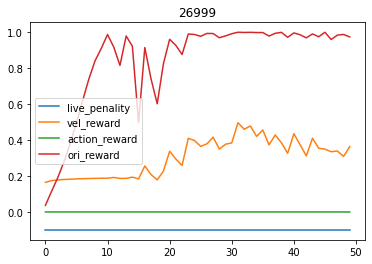

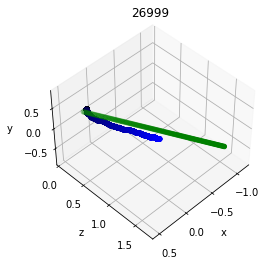

| eval  | E: 539 | S: 26999 | R: 52.4069
| train | E: 540 | S: 26999 | R: 60.1039 | D: 34.9 s | BR: 0.6986 | ALOSS: -35.6110 | CLOSS: 26.0044 | TLOSS: 0.7139 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 541 | S: 27049 | R: 49.4378 | D: 72.3 s | BR: 0.7028 | ALOSS: -35.7158 | CLOSS: 24.1435 | TLOSS: 0.0431 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 542 | S: 27099 | R: 59.7812 | D: 34.8 s | BR: 0.6974 | ALOSS: -35.6759 | CLOSS: 21.2109 | TLOSS: -0.1369 | TVAL: 0.0502 | AENT: -4.0000
| train | E: 543 | S: 27149 | R: 47.7506 | D: 35.5 s | BR: 0.6928 | ALOSS: -35.4791 | CLOSS: 22.7281 | TLOSS: -0.1285 | TVAL: 0.0500 | AENT: -4.0000
| train | E: 544 | S: 27199 | R: 57.8962 | D: 35.1 s | BR: 0.6871 | ALOSS: -35.5778 | CLOSS: 20.8920 | TLOSS: -0.6829 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 545 | S: 27249 | R: 60.9860 | D: 35.6 s | BR: 0.6901 | ALOSS: -35.6398 | CLOSS: 15.1282 | TLOSS: 0.5154 | TVAL: 0.0498 | AENT: -4.0000
| train | E: 546 | S: 27299 | R: 53.5224 | D: 34.7 s | BR: 0.6919 | 

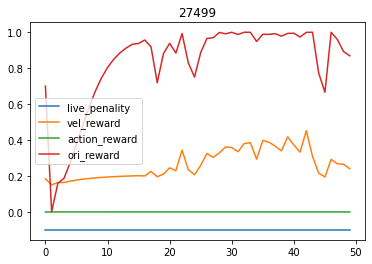

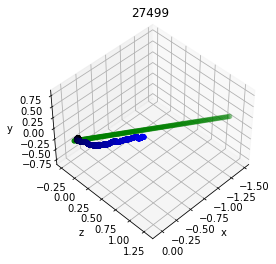

| eval  | E: 549 | S: 27499 | R: 49.3860
| train | E: 550 | S: 27499 | R: 61.4853 | D: 35.1 s | BR: 0.6988 | ALOSS: -35.7816 | CLOSS: 19.5088 | TLOSS: 1.4390 | TVAL: 0.0504 | AENT: -4.0000
| train | E: 551 | S: 27549 | R: 48.9499 | D: 69.1 s | BR: 0.6924 | ALOSS: -35.4121 | CLOSS: 26.6161 | TLOSS: 1.0046 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 552 | S: 27599 | R: 54.4785 | D: 35.7 s | BR: 0.7103 | ALOSS: -36.1098 | CLOSS: 20.4808 | TLOSS: -0.9241 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 553 | S: 27649 | R: 48.8993 | D: 35.1 s | BR: 0.7060 | ALOSS: -36.0983 | CLOSS: 16.7061 | TLOSS: 0.2439 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 554 | S: 27699 | R: 56.1502 | D: 35.1 s | BR: 0.6949 | ALOSS: -35.6693 | CLOSS: 24.8681 | TLOSS: 0.5850 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 555 | S: 27749 | R: 50.8886 | D: 38.0 s | BR: 0.7254 | ALOSS: -35.9218 | CLOSS: 23.5730 | TLOSS: -0.2401 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 556 | S: 27799 | R: 50.4800 | D: 35.0 s | BR: 0.6940 | A

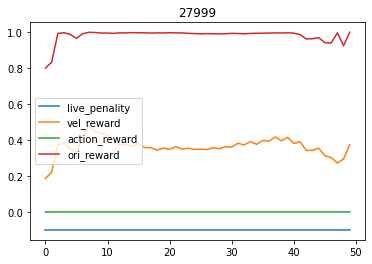

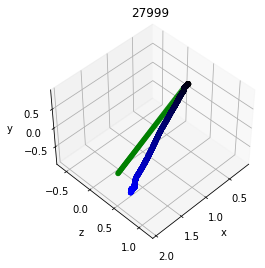

| eval  | E: 559 | S: 27999 | R: 62.2476
| train | E: 560 | S: 27999 | R: 59.3644 | D: 35.6 s | BR: 0.7308 | ALOSS: -36.1760 | CLOSS: 21.7921 | TLOSS: -0.4139 | TVAL: 0.0508 | AENT: -4.0000
| train | E: 561 | S: 28049 | R: 54.4993 | D: 75.2 s | BR: 0.7173 | ALOSS: -36.1339 | CLOSS: 24.0816 | TLOSS: -0.2373 | TVAL: 0.0506 | AENT: -4.0000
| train | E: 562 | S: 28099 | R: 56.5287 | D: 32.6 s | BR: 0.7042 | ALOSS: -36.0372 | CLOSS: 19.6085 | TLOSS: -1.2224 | TVAL: 0.0503 | AENT: -4.0000
| train | E: 563 | S: 28149 | R: 49.8229 | D: 34.9 s | BR: 0.7133 | ALOSS: -36.2207 | CLOSS: 22.9622 | TLOSS: -0.6396 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 564 | S: 28199 | R: 57.2360 | D: 33.9 s | BR: 0.7153 | ALOSS: -36.1707 | CLOSS: 21.9808 | TLOSS: -0.5709 | TVAL: 0.0496 | AENT: -4.0000
| train | E: 565 | S: 28249 | R: 54.6307 | D: 33.6 s | BR: 0.7208 | ALOSS: -35.9190 | CLOSS: 26.7731 | TLOSS: -0.3678 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 566 | S: 28299 | R: 56.4152 | D: 34.1 s | BR: 0.7090

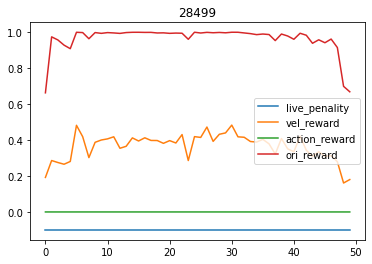

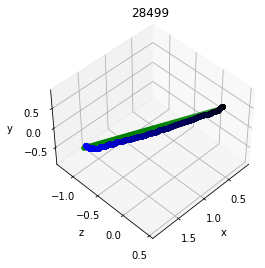

| eval  | E: 569 | S: 28499 | R: 61.4405
| train | E: 570 | S: 28499 | R: 52.9176 | D: 35.0 s | BR: 0.7155 | ALOSS: -36.2095 | CLOSS: 21.6903 | TLOSS: -0.7658 | TVAL: 0.0491 | AENT: -4.0000
| train | E: 571 | S: 28549 | R: 51.3045 | D: 74.1 s | BR: 0.7266 | ALOSS: -36.2035 | CLOSS: 23.0558 | TLOSS: -0.3143 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 572 | S: 28599 | R: 58.7197 | D: 36.6 s | BR: 0.7261 | ALOSS: -36.4630 | CLOSS: 27.4464 | TLOSS: -0.9637 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 573 | S: 28649 | R: 51.5086 | D: 34.2 s | BR: 0.7037 | ALOSS: -36.2456 | CLOSS: 19.9341 | TLOSS: 0.0302 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 574 | S: 28699 | R: 48.8871 | D: 35.7 s | BR: 0.7206 | ALOSS: -36.5725 | CLOSS: 14.2713 | TLOSS: 0.7611 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 575 | S: 28749 | R: 61.7980 | D: 37.3 s | BR: 0.7159 | ALOSS: -36.4071 | CLOSS: 20.3570 | TLOSS: 0.6348 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 576 | S: 28799 | R: 58.6597 | D: 33.9 s | BR: 0.7187 | 

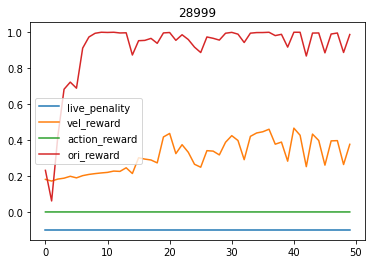

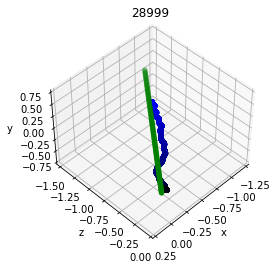

| eval  | E: 579 | S: 28999 | R: 55.9837
| train | E: 580 | S: 28999 | R: 57.3981 | D: 34.6 s | BR: 0.7224 | ALOSS: -36.7185 | CLOSS: 21.3683 | TLOSS: 0.5324 | TVAL: 0.0499 | AENT: -4.0000
| train | E: 581 | S: 29049 | R: 57.9632 | D: 71.0 s | BR: 0.7456 | ALOSS: -36.8600 | CLOSS: 17.0467 | TLOSS: 0.1140 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 582 | S: 29099 | R: 62.3902 | D: 34.1 s | BR: 0.7323 | ALOSS: -36.8463 | CLOSS: 22.5453 | TLOSS: 0.3457 | TVAL: 0.0502 | AENT: -4.0000
| train | E: 583 | S: 29149 | R: 55.8358 | D: 34.5 s | BR: 0.7324 | ALOSS: -36.9467 | CLOSS: 19.1855 | TLOSS: 0.5851 | TVAL: 0.0503 | AENT: -4.0000
| train | E: 584 | S: 29199 | R: 50.8482 | D: 34.9 s | BR: 0.7231 | ALOSS: -36.6703 | CLOSS: 24.2969 | TLOSS: 0.7920 | TVAL: 0.0507 | AENT: -4.0000
| train | E: 585 | S: 29249 | R: 57.9862 | D: 34.2 s | BR: 0.7235 | ALOSS: -36.5613 | CLOSS: 27.5250 | TLOSS: 0.0000 | TVAL: 0.0509 | AENT: -4.0000
| train | E: 586 | S: 29299 | R: 60.2072 | D: 34.3 s | BR: 0.7487 | ALO

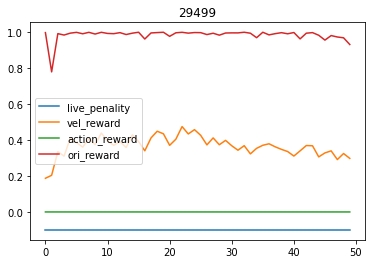

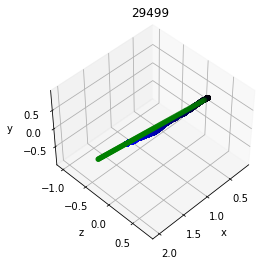

| eval  | E: 589 | S: 29499 | R: 62.5958
| train | E: 590 | S: 29499 | R: 57.0454 | D: 38.0 s | BR: 0.7423 | ALOSS: -37.0327 | CLOSS: 22.2897 | TLOSS: 0.1814 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 591 | S: 29549 | R: 59.7809 | D: 69.2 s | BR: 0.7096 | ALOSS: -36.7985 | CLOSS: 17.9934 | TLOSS: 0.1195 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 592 | S: 29599 | R: 52.0261 | D: 33.5 s | BR: 0.7236 | ALOSS: -36.6792 | CLOSS: 23.8511 | TLOSS: 0.3275 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 593 | S: 29649 | R: 58.7488 | D: 34.3 s | BR: 0.7358 | ALOSS: -36.7517 | CLOSS: 23.0727 | TLOSS: -0.7050 | TVAL: 0.0515 | AENT: -4.0000
| train | E: 594 | S: 29699 | R: 47.8333 | D: 34.7 s | BR: 0.7488 | ALOSS: -37.3307 | CLOSS: 18.1658 | TLOSS: -0.4104 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 595 | S: 29749 | R: 51.7798 | D: 34.2 s | BR: 0.7390 | ALOSS: -36.9251 | CLOSS: 22.1179 | TLOSS: -0.2445 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 596 | S: 29799 | R: 50.1753 | D: 35.0 s | BR: 0.7391 | 

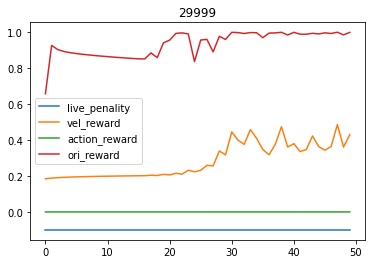

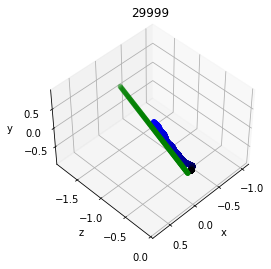

| eval  | E: 599 | S: 29999 | R: 55.9506
| train | E: 600 | S: 29999 | R: 59.5279 | D: 39.0 s | BR: 0.7374 | ALOSS: -37.3965 | CLOSS: 24.6485 | TLOSS: 1.2226 | TVAL: 0.0512 | AENT: -4.0000
| train | E: 601 | S: 30049 | R: 62.2437 | D: 69.8 s | BR: 0.7479 | ALOSS: -37.1036 | CLOSS: 25.6554 | TLOSS: 0.3557 | TVAL: 0.0519 | AENT: -4.0000
| train | E: 602 | S: 30099 | R: 49.1897 | D: 34.4 s | BR: 0.7416 | ALOSS: -37.0105 | CLOSS: 25.5195 | TLOSS: -0.2413 | TVAL: 0.0518 | AENT: -4.0000
| train | E: 603 | S: 30149 | R: 57.1330 | D: 35.0 s | BR: 0.7386 | ALOSS: -37.0241 | CLOSS: 30.1481 | TLOSS: 0.1560 | TVAL: 0.0518 | AENT: -4.0000
| train | E: 604 | S: 30199 | R: 54.4492 | D: 34.9 s | BR: 0.7461 | ALOSS: -37.1533 | CLOSS: 21.5391 | TLOSS: 1.1487 | TVAL: 0.0520 | AENT: -4.0000
| train | E: 605 | S: 30249 | R: 54.8531 | D: 34.5 s | BR: 0.7317 | ALOSS: -36.9412 | CLOSS: 25.3766 | TLOSS: 0.3391 | TVAL: 0.0525 | AENT: -4.0000
| train | E: 606 | S: 30299 | R: 57.7298 | D: 35.5 s | BR: 0.7311 | AL

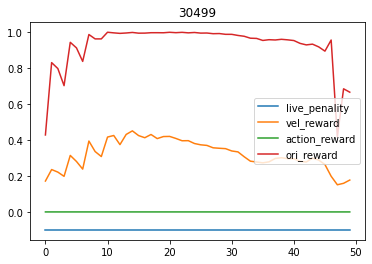

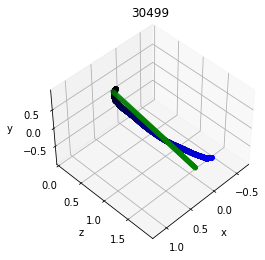

| eval  | E: 609 | S: 30499 | R: 57.2468
| train | E: 610 | S: 30499 | R: 42.0023 | D: 35.0 s | BR: 0.7483 | ALOSS: -37.3038 | CLOSS: 26.1037 | TLOSS: -0.7296 | TVAL: 0.0515 | AENT: -4.0000
| train | E: 611 | S: 30549 | R: 53.3594 | D: 70.1 s | BR: 0.7519 | ALOSS: -37.3573 | CLOSS: 25.8636 | TLOSS: -0.7261 | TVAL: 0.0511 | AENT: -4.0000
| train | E: 612 | S: 30599 | R: 58.5908 | D: 38.5 s | BR: 0.7266 | ALOSS: -37.0516 | CLOSS: 22.7500 | TLOSS: 0.6412 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 613 | S: 30649 | R: 61.9983 | D: 35.4 s | BR: 0.7325 | ALOSS: -37.2289 | CLOSS: 21.0363 | TLOSS: 0.2219 | TVAL: 0.0512 | AENT: -4.0000
| train | E: 614 | S: 30699 | R: 54.1662 | D: 34.9 s | BR: 0.7446 | ALOSS: -36.9865 | CLOSS: 24.0007 | TLOSS: 0.3617 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 615 | S: 30749 | R: 54.7791 | D: 34.1 s | BR: 0.7404 | ALOSS: -37.3220 | CLOSS: 19.8125 | TLOSS: -0.0509 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 616 | S: 30799 | R: 57.2522 | D: 36.7 s | BR: 0.7328 | 

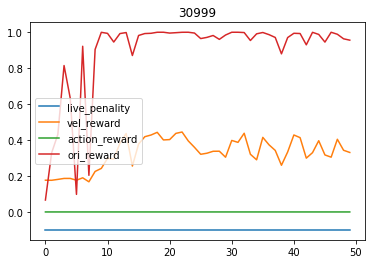

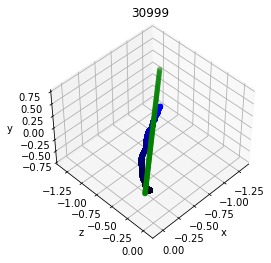

| eval  | E: 619 | S: 30999 | R: 55.9649
| train | E: 620 | S: 30999 | R: 50.3406 | D: 34.9 s | BR: 0.7464 | ALOSS: -37.4305 | CLOSS: 25.7504 | TLOSS: 0.3978 | TVAL: 0.0521 | AENT: -4.0000
| train | E: 621 | S: 31049 | R: 53.0074 | D: 76.0 s | BR: 0.7498 | ALOSS: -37.5056 | CLOSS: 22.6363 | TLOSS: -0.0814 | TVAL: 0.0523 | AENT: -4.0000
| train | E: 622 | S: 31099 | R: 60.6781 | D: 37.3 s | BR: 0.7498 | ALOSS: -37.2801 | CLOSS: 26.1035 | TLOSS: -0.2155 | TVAL: 0.0523 | AENT: -4.0000
| train | E: 623 | S: 31149 | R: 59.0993 | D: 38.6 s | BR: 0.7596 | ALOSS: -37.7719 | CLOSS: 19.1468 | TLOSS: 0.2386 | TVAL: 0.0522 | AENT: -4.0000
| train | E: 624 | S: 31199 | R: 53.2391 | D: 35.7 s | BR: 0.7394 | ALOSS: -37.3151 | CLOSS: 19.5179 | TLOSS: -0.1365 | TVAL: 0.0523 | AENT: -4.0000
| train | E: 625 | S: 31249 | R: 46.9242 | D: 38.2 s | BR: 0.7548 | ALOSS: -37.6382 | CLOSS: 20.8576 | TLOSS: -0.4273 | TVAL: 0.0521 | AENT: -4.0000
| train | E: 626 | S: 31299 | R: 55.8703 | D: 34.9 s | BR: 0.7415 |

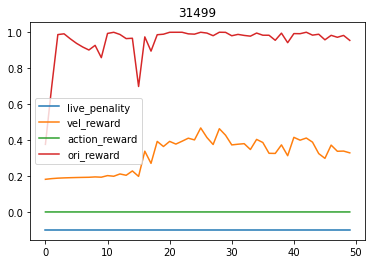

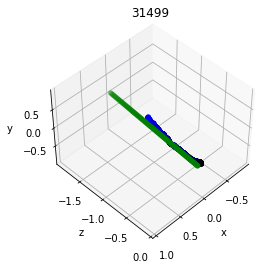

| eval  | E: 629 | S: 31499 | R: 58.4029
| train | E: 630 | S: 31499 | R: 53.6223 | D: 35.5 s | BR: 0.7544 | ALOSS: -37.5987 | CLOSS: 21.8782 | TLOSS: -0.2253 | TVAL: 0.0509 | AENT: -4.0000
| train | E: 631 | S: 31549 | R: 54.2693 | D: 70.2 s | BR: 0.7479 | ALOSS: -37.6244 | CLOSS: 20.8965 | TLOSS: 0.5267 | TVAL: 0.0509 | AENT: -4.0000
| train | E: 632 | S: 31599 | R: 44.1968 | D: 35.5 s | BR: 0.7736 | ALOSS: -37.6471 | CLOSS: 23.3556 | TLOSS: -0.7528 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 633 | S: 31649 | R: 57.9059 | D: 35.1 s | BR: 0.7447 | ALOSS: -37.3032 | CLOSS: 24.7657 | TLOSS: -0.0331 | TVAL: 0.0508 | AENT: -4.0000
| train | E: 634 | S: 31699 | R: 54.2753 | D: 37.1 s | BR: 0.7562 | ALOSS: -37.3085 | CLOSS: 28.4138 | TLOSS: -0.0954 | TVAL: 0.0507 | AENT: -4.0000
| train | E: 635 | S: 31749 | R: 57.7856 | D: 35.1 s | BR: 0.7542 | ALOSS: -37.0811 | CLOSS: 24.3274 | TLOSS: -1.0753 | TVAL: 0.0505 | AENT: -4.0000
| train | E: 636 | S: 31799 | R: 61.1618 | D: 35.1 s | BR: 0.7719 

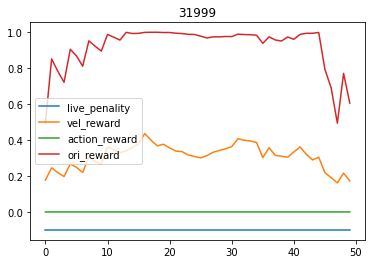

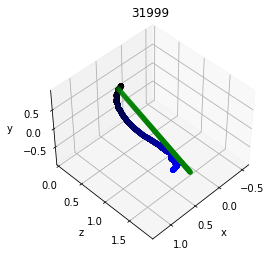

| eval  | E: 639 | S: 31999 | R: 56.4781
| train | E: 640 | S: 31999 | R: 52.8828 | D: 35.6 s | BR: 0.7549 | ALOSS: -37.3038 | CLOSS: 25.6299 | TLOSS: -0.6083 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 641 | S: 32049 | R: 56.0279 | D: 73.0 s | BR: 0.7725 | ALOSS: -37.3371 | CLOSS: 27.8213 | TLOSS: 0.0324 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 642 | S: 32099 | R: 61.4256 | D: 35.0 s | BR: 0.7677 | ALOSS: -37.4426 | CLOSS: 23.4821 | TLOSS: -0.6256 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 643 | S: 32149 | R: 57.3148 | D: 34.8 s | BR: 0.7704 | ALOSS: -37.5598 | CLOSS: 18.8262 | TLOSS: 0.1346 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 644 | S: 32199 | R: 56.5239 | D: 34.8 s | BR: 0.7609 | ALOSS: -37.3564 | CLOSS: 26.5608 | TLOSS: 0.1454 | TVAL: 0.0484 | AENT: -4.0000
| train | E: 645 | S: 32249 | R: 52.9542 | D: 34.4 s | BR: 0.7514 | ALOSS: -37.4645 | CLOSS: 24.5898 | TLOSS: 0.6390 | TVAL: 0.0485 | AENT: -4.0000
| train | E: 646 | S: 32299 | R: 59.2384 | D: 36.9 s | BR: 0.7669 | A

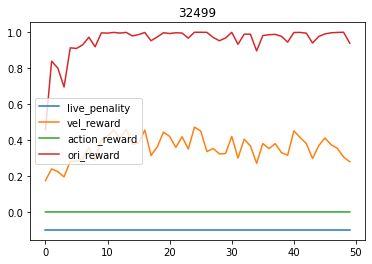

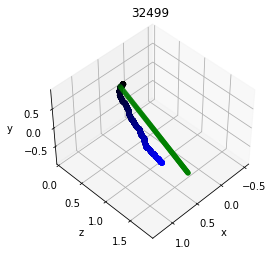

| eval  | E: 649 | S: 32499 | R: 60.4670
| train | E: 650 | S: 32499 | R: 50.7395 | D: 42.2 s | BR: 0.7645 | ALOSS: -38.0435 | CLOSS: 17.4522 | TLOSS: 0.0016 | TVAL: 0.0493 | AENT: -4.0000
| train | E: 651 | S: 32549 | R: 57.3930 | D: 77.2 s | BR: 0.7705 | ALOSS: -37.5959 | CLOSS: 24.5429 | TLOSS: 0.1877 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 652 | S: 32599 | R: 53.0354 | D: 39.2 s | BR: 0.7686 | ALOSS: -37.5117 | CLOSS: 27.9840 | TLOSS: -0.4286 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 653 | S: 32649 | R: 59.6571 | D: 38.9 s | BR: 0.7620 | ALOSS: -37.2544 | CLOSS: 26.3825 | TLOSS: -0.7295 | TVAL: 0.0491 | AENT: -4.0000
| train | E: 654 | S: 32699 | R: 49.4180 | D: 39.9 s | BR: 0.7621 | ALOSS: -37.4976 | CLOSS: 22.2886 | TLOSS: 0.4503 | TVAL: 0.0490 | AENT: -4.0000
| train | E: 655 | S: 32749 | R: 52.0749 | D: 37.8 s | BR: 0.7666 | ALOSS: -37.4048 | CLOSS: 25.6660 | TLOSS: -0.2308 | TVAL: 0.0490 | AENT: -4.0000
| train | E: 656 | S: 32799 | R: 49.0645 | D: 39.4 s | BR: 0.7640 | 

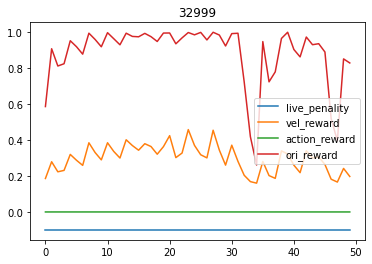

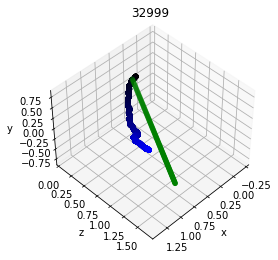

| eval  | E: 659 | S: 32999 | R: 54.0676
| train | E: 660 | S: 32999 | R: 53.8924 | D: 40.8 s | BR: 0.7777 | ALOSS: -37.9341 | CLOSS: 21.8498 | TLOSS: 0.0872 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 661 | S: 33049 | R: 56.4492 | D: 79.3 s | BR: 0.7620 | ALOSS: -37.7634 | CLOSS: 21.0388 | TLOSS: 0.6158 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 662 | S: 33099 | R: 47.4222 | D: 45.9 s | BR: 0.7739 | ALOSS: -37.9321 | CLOSS: 25.2207 | TLOSS: 0.4190 | TVAL: 0.0490 | AENT: -4.0000
| train | E: 663 | S: 33149 | R: 57.0631 | D: 40.3 s | BR: 0.7681 | ALOSS: -37.6680 | CLOSS: 23.6491 | TLOSS: 0.0689 | TVAL: 0.0492 | AENT: -4.0000
| train | E: 664 | S: 33199 | R: 55.5243 | D: 47.2 s | BR: 0.7840 | ALOSS: -37.5818 | CLOSS: 30.2453 | TLOSS: 0.5886 | TVAL: 0.0493 | AENT: -4.0000
| train | E: 665 | S: 33249 | R: 62.5614 | D: 42.3 s | BR: 0.7695 | ALOSS: -37.6793 | CLOSS: 25.8076 | TLOSS: -0.3354 | TVAL: 0.0494 | AENT: -4.0000
| train | E: 666 | S: 33299 | R: 54.6382 | D: 43.1 s | BR: 0.7648 | AL

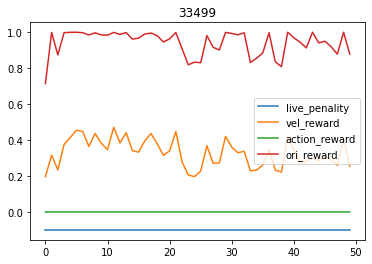

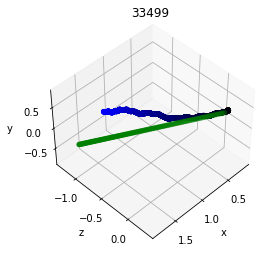

| eval  | E: 669 | S: 33499 | R: 58.5646
| train | E: 670 | S: 33499 | R: 51.1560 | D: 43.9 s | BR: 0.7674 | ALOSS: -37.9417 | CLOSS: 25.9152 | TLOSS: -0.2789 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 671 | S: 33549 | R: 54.8404 | D: 84.5 s | BR: 0.7596 | ALOSS: -37.5821 | CLOSS: 22.3974 | TLOSS: 0.7463 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 672 | S: 33599 | R: 54.9833 | D: 41.3 s | BR: 0.7744 | ALOSS: -37.6133 | CLOSS: 27.0977 | TLOSS: -0.1687 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 673 | S: 33649 | R: 56.0419 | D: 42.6 s | BR: 0.7776 | ALOSS: -37.7804 | CLOSS: 24.0565 | TLOSS: -0.8832 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 674 | S: 33699 | R: 40.7702 | D: 44.2 s | BR: 0.7726 | ALOSS: -37.8768 | CLOSS: 23.1084 | TLOSS: 0.1875 | TVAL: 0.0484 | AENT: -4.0000
| train | E: 675 | S: 33749 | R: 57.8540 | D: 41.1 s | BR: 0.7830 | ALOSS: -37.8603 | CLOSS: 19.4084 | TLOSS: -0.4342 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 676 | S: 33799 | R: 60.1142 | D: 41.7 s | BR: 0.7802 |

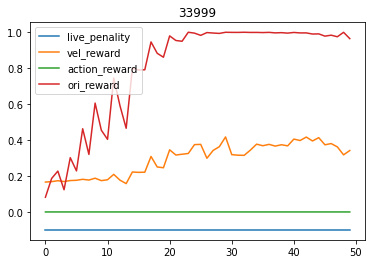

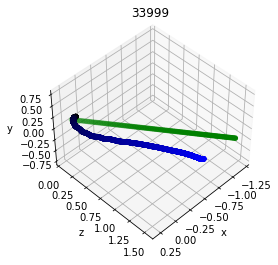

| eval  | E: 679 | S: 33999 | R: 49.7240
| train | E: 680 | S: 33999 | R: 58.0065 | D: 42.6 s | BR: 0.7757 | ALOSS: -37.6706 | CLOSS: 23.5103 | TLOSS: 0.0174 | TVAL: 0.0474 | AENT: -4.0000
| train | E: 681 | S: 34049 | R: 46.6253 | D: 88.8 s | BR: 0.7832 | ALOSS: -37.9932 | CLOSS: 22.7896 | TLOSS: -0.2343 | TVAL: 0.0474 | AENT: -4.0000
| train | E: 682 | S: 34099 | R: 59.4634 | D: 42.8 s | BR: 0.7715 | ALOSS: -38.0486 | CLOSS: 23.3795 | TLOSS: -0.3118 | TVAL: 0.0474 | AENT: -4.0000
| train | E: 683 | S: 34149 | R: 55.4669 | D: 43.2 s | BR: 0.7817 | ALOSS: -37.8641 | CLOSS: 25.0783 | TLOSS: -0.2216 | TVAL: 0.0472 | AENT: -4.0000
| train | E: 684 | S: 34199 | R: 49.2103 | D: 45.1 s | BR: 0.7836 | ALOSS: -38.2341 | CLOSS: 17.8985 | TLOSS: 0.9557 | TVAL: 0.0473 | AENT: -4.0000
| train | E: 685 | S: 34249 | R: 44.7056 | D: 44.1 s | BR: 0.7795 | ALOSS: -38.1739 | CLOSS: 22.6472 | TLOSS: 0.2496 | TVAL: 0.0476 | AENT: -4.0000
| train | E: 686 | S: 34299 | R: 55.0812 | D: 43.1 s | BR: 0.7757 | 

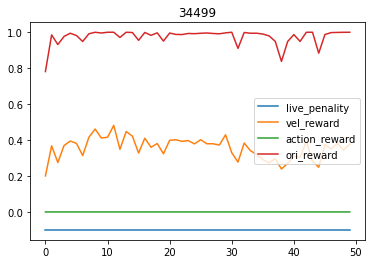

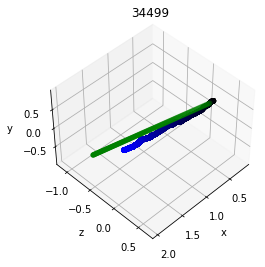

| eval  | E: 689 | S: 34499 | R: 61.6008
| train | E: 690 | S: 34499 | R: 59.4392 | D: 43.0 s | BR: 0.7778 | ALOSS: -37.8098 | CLOSS: 27.6189 | TLOSS: -0.8383 | TVAL: 0.0489 | AENT: -4.0000
| train | E: 691 | S: 34549 | R: 51.9720 | D: 86.5 s | BR: 0.7944 | ALOSS: -38.4386 | CLOSS: 21.1437 | TLOSS: -0.0191 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 692 | S: 34599 | R: 59.7982 | D: 47.3 s | BR: 0.8040 | ALOSS: -38.3117 | CLOSS: 24.1479 | TLOSS: 0.0935 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 693 | S: 34649 | R: 51.8465 | D: 46.4 s | BR: 0.7898 | ALOSS: -38.1203 | CLOSS: 26.5363 | TLOSS: -0.3568 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 694 | S: 34699 | R: 49.6114 | D: 43.0 s | BR: 0.7825 | ALOSS: -38.1968 | CLOSS: 26.0178 | TLOSS: 0.0337 | TVAL: 0.0485 | AENT: -4.0000
| train | E: 695 | S: 34749 | R: 53.8189 | D: 42.8 s | BR: 0.7712 | ALOSS: -37.9997 | CLOSS: 24.3759 | TLOSS: 0.1576 | TVAL: 0.0485 | AENT: -4.0000
| train | E: 696 | S: 34799 | R: 57.6179 | D: 44.9 s | BR: 0.7908 | 

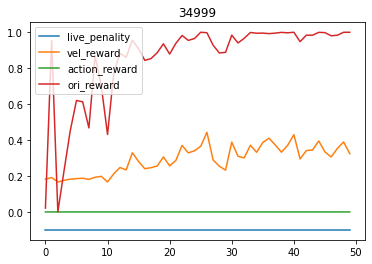

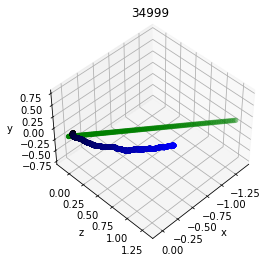

| eval  | E: 699 | S: 34999 | R: 52.0252
| train | E: 700 | S: 34999 | R: 57.7549 | D: 42.6 s | BR: 0.8007 | ALOSS: -38.5025 | CLOSS: 24.8635 | TLOSS: -0.3866 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 701 | S: 35049 | R: 40.0771 | D: 82.8 s | BR: 0.7846 | ALOSS: -38.2839 | CLOSS: 25.3002 | TLOSS: 0.0035 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 702 | S: 35099 | R: 58.3895 | D: 42.7 s | BR: 0.7795 | ALOSS: -38.3258 | CLOSS: 20.9113 | TLOSS: -0.0689 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 703 | S: 35149 | R: 51.5184 | D: 46.1 s | BR: 0.7952 | ALOSS: -38.7088 | CLOSS: 14.1325 | TLOSS: 0.1841 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 704 | S: 35199 | R: 55.3865 | D: 42.6 s | BR: 0.7795 | ALOSS: -38.3589 | CLOSS: 25.5976 | TLOSS: -0.1602 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 705 | S: 35249 | R: 45.7438 | D: 43.0 s | BR: 0.7776 | ALOSS: -38.3526 | CLOSS: 22.3144 | TLOSS: -0.3068 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 706 | S: 35299 | R: 35.5576 | D: 42.9 s | BR: 0.7933 |

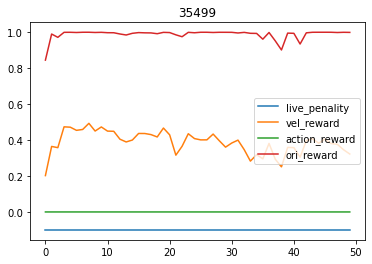

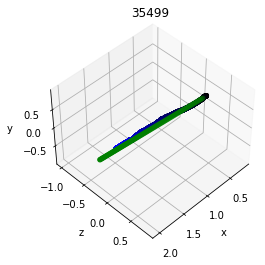

| eval  | E: 709 | S: 35499 | R: 63.8318
| train | E: 710 | S: 35499 | R: 51.5520 | D: 42.5 s | BR: 0.7936 | ALOSS: -38.5403 | CLOSS: 24.5038 | TLOSS: 0.2808 | TVAL: 0.0491 | AENT: -4.0000
| train | E: 711 | S: 35549 | R: 53.2336 | D: 85.0 s | BR: 0.7821 | ALOSS: -38.4630 | CLOSS: 24.0283 | TLOSS: -0.1009 | TVAL: 0.0493 | AENT: -4.0000
| train | E: 712 | S: 35599 | R: 55.4995 | D: 45.3 s | BR: 0.8109 | ALOSS: -38.6939 | CLOSS: 27.5847 | TLOSS: -0.1554 | TVAL: 0.0491 | AENT: -4.0000
| train | E: 713 | S: 35649 | R: 55.6961 | D: 42.1 s | BR: 0.7977 | ALOSS: -38.4720 | CLOSS: 25.7520 | TLOSS: -0.5730 | TVAL: 0.0491 | AENT: -4.0000
| train | E: 714 | S: 35699 | R: 52.8184 | D: 42.9 s | BR: 0.7943 | ALOSS: -38.7025 | CLOSS: 21.1974 | TLOSS: -0.5268 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 715 | S: 35749 | R: 53.1557 | D: 42.5 s | BR: 0.8097 | ALOSS: -38.8138 | CLOSS: 21.3248 | TLOSS: -0.1362 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 716 | S: 35799 | R: 56.9837 | D: 42.5 s | BR: 0.7800 

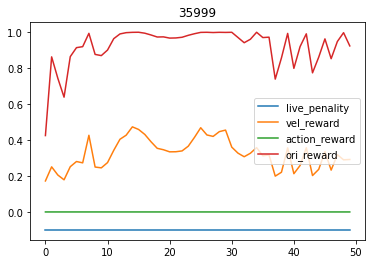

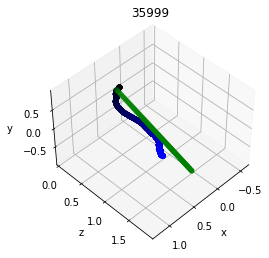

| eval  | E: 719 | S: 35999 | R: 57.4673
| train | E: 720 | S: 35999 | R: 46.6778 | D: 42.5 s | BR: 0.7951 | ALOSS: -38.4002 | CLOSS: 29.3364 | TLOSS: -0.8288 | TVAL: 0.0472 | AENT: -4.0000
| train | E: 721 | S: 36049 | R: 56.3940 | D: 85.2 s | BR: 0.7744 | ALOSS: -38.4297 | CLOSS: 24.2261 | TLOSS: 0.0808 | TVAL: 0.0470 | AENT: -4.0000
| train | E: 722 | S: 36099 | R: 56.1058 | D: 42.9 s | BR: 0.7936 | ALOSS: -38.2190 | CLOSS: 33.0205 | TLOSS: -0.1351 | TVAL: 0.0470 | AENT: -4.0000
| train | E: 723 | S: 36149 | R: 49.1419 | D: 42.8 s | BR: 0.8008 | ALOSS: -38.2235 | CLOSS: 26.3624 | TLOSS: -0.3150 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 724 | S: 36199 | R: 57.5105 | D: 42.8 s | BR: 0.8032 | ALOSS: -38.6790 | CLOSS: 21.0669 | TLOSS: -0.2428 | TVAL: 0.0468 | AENT: -4.0000
| train | E: 725 | S: 36249 | R: 57.0126 | D: 43.4 s | BR: 0.8004 | ALOSS: -38.5660 | CLOSS: 21.9587 | TLOSS: 0.0513 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 726 | S: 36299 | R: 53.5775 | D: 37.5 s | BR: 0.8065 |

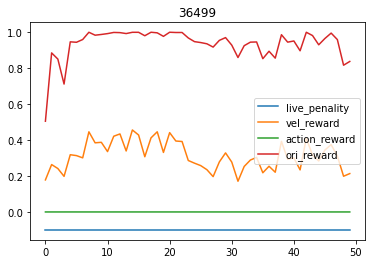

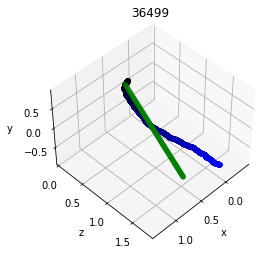

| eval  | E: 729 | S: 36499 | R: 57.4998
| train | E: 730 | S: 36499 | R: 59.7833 | D: 42.7 s | BR: 0.7989 | ALOSS: -38.5603 | CLOSS: 17.0829 | TLOSS: -0.7146 | TVAL: 0.0465 | AENT: -4.0000
| train | E: 731 | S: 36549 | R: 55.4008 | D: 88.8 s | BR: 0.7913 | ALOSS: -38.6146 | CLOSS: 26.0315 | TLOSS: 0.7425 | TVAL: 0.0464 | AENT: -4.0000
| train | E: 732 | S: 36599 | R: 61.1318 | D: 43.3 s | BR: 0.7964 | ALOSS: -38.5165 | CLOSS: 21.9530 | TLOSS: 0.1860 | TVAL: 0.0466 | AENT: -4.0000
| train | E: 733 | S: 36649 | R: 49.0599 | D: 46.6 s | BR: 0.8013 | ALOSS: -38.5085 | CLOSS: 24.8101 | TLOSS: -0.4754 | TVAL: 0.0466 | AENT: -4.0000
| train | E: 734 | S: 36699 | R: 57.7324 | D: 43.3 s | BR: 0.8217 | ALOSS: -38.9189 | CLOSS: 24.2575 | TLOSS: -0.5090 | TVAL: 0.0464 | AENT: -4.0000
| train | E: 735 | S: 36749 | R: 56.5079 | D: 42.6 s | BR: 0.8015 | ALOSS: -38.8314 | CLOSS: 18.1148 | TLOSS: 0.6348 | TVAL: 0.0463 | AENT: -4.0000
| train | E: 736 | S: 36799 | R: 54.8226 | D: 43.0 s | BR: 0.8014 | 

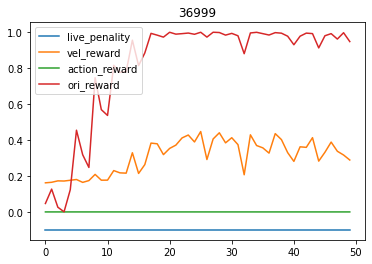

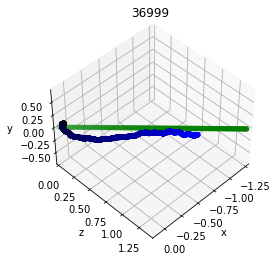

| eval  | E: 739 | S: 36999 | R: 50.8995
| train | E: 740 | S: 36999 | R: 57.7151 | D: 43.0 s | BR: 0.8140 | ALOSS: -38.8921 | CLOSS: 25.9189 | TLOSS: 0.0281 | TVAL: 0.0470 | AENT: -4.0000
| train | E: 741 | S: 37049 | R: 55.3863 | D: 85.2 s | BR: 0.7989 | ALOSS: -38.7271 | CLOSS: 27.0638 | TLOSS: -0.3806 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 742 | S: 37099 | R: 57.3571 | D: 46.9 s | BR: 0.8076 | ALOSS: -38.5310 | CLOSS: 24.3869 | TLOSS: -0.7669 | TVAL: 0.0468 | AENT: -4.0000
| train | E: 743 | S: 37149 | R: 52.4642 | D: 43.6 s | BR: 0.8155 | ALOSS: -39.0765 | CLOSS: 16.8965 | TLOSS: 0.4577 | TVAL: 0.0466 | AENT: -4.0000
| train | E: 744 | S: 37199 | R: 51.2598 | D: 43.1 s | BR: 0.7889 | ALOSS: -38.3632 | CLOSS: 36.1663 | TLOSS: -0.6931 | TVAL: 0.0466 | AENT: -4.0000
| train | E: 745 | S: 37249 | R: 60.1513 | D: 43.0 s | BR: 0.8083 | ALOSS: -39.1637 | CLOSS: 21.5292 | TLOSS: -0.4154 | TVAL: 0.0464 | AENT: -4.0000
| train | E: 746 | S: 37299 | R: 57.5331 | D: 45.4 s | BR: 0.8109 |

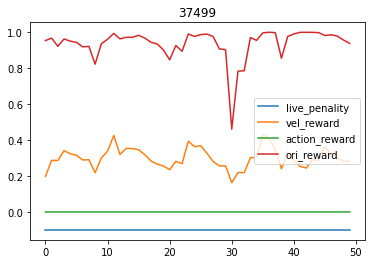

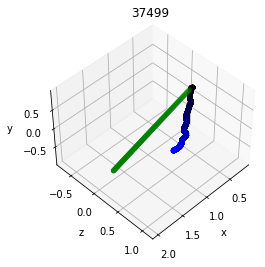

| eval  | E: 749 | S: 37499 | R: 56.9208
| train | E: 750 | S: 37499 | R: 57.8159 | D: 43.3 s | BR: 0.8164 | ALOSS: -39.0089 | CLOSS: 26.9838 | TLOSS: -0.1268 | TVAL: 0.0454 | AENT: -4.0000
| train | E: 751 | S: 37549 | R: 55.6203 | D: 75.5 s | BR: 0.8100 | ALOSS: -38.8509 | CLOSS: 30.0380 | TLOSS: -0.8435 | TVAL: 0.0453 | AENT: -4.0000
| train | E: 752 | S: 37599 | R: 55.7311 | D: 36.1 s | BR: 0.8117 | ALOSS: -39.0181 | CLOSS: 23.4159 | TLOSS: 0.0377 | TVAL: 0.0451 | AENT: -4.0000
| train | E: 753 | S: 37649 | R: 62.0794 | D: 40.2 s | BR: 0.8156 | ALOSS: -39.0115 | CLOSS: 23.0267 | TLOSS: -1.2545 | TVAL: 0.0448 | AENT: -4.0000
| train | E: 754 | S: 37699 | R: 53.5951 | D: 35.9 s | BR: 0.8179 | ALOSS: -39.0402 | CLOSS: 23.6221 | TLOSS: -1.3816 | TVAL: 0.0444 | AENT: -4.0000
| train | E: 755 | S: 37749 | R: 58.8381 | D: 36.6 s | BR: 0.8190 | ALOSS: -38.6475 | CLOSS: 31.6651 | TLOSS: -0.4811 | TVAL: 0.0439 | AENT: -4.0000
| train | E: 756 | S: 37799 | R: 55.7492 | D: 36.0 s | BR: 0.8167 

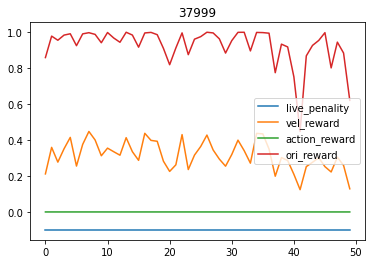

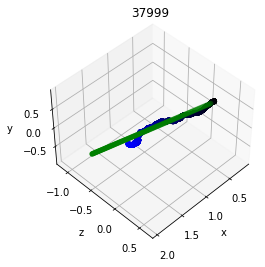

| eval  | E: 759 | S: 37999 | R: 57.1527
| train | E: 760 | S: 37999 | R: 56.9946 | D: 37.1 s | BR: 0.8013 | ALOSS: -38.4874 | CLOSS: 30.2382 | TLOSS: -0.1361 | TVAL: 0.0440 | AENT: -4.0000
| train | E: 761 | S: 38049 | R: 50.4269 | D: 72.3 s | BR: 0.8221 | ALOSS: -38.9175 | CLOSS: 29.0023 | TLOSS: -0.0700 | TVAL: 0.0439 | AENT: -4.0000
| train | E: 762 | S: 38099 | R: 48.9272 | D: 37.0 s | BR: 0.8220 | ALOSS: -38.8250 | CLOSS: 25.9238 | TLOSS: 0.2799 | TVAL: 0.0440 | AENT: -4.0000
| train | E: 763 | S: 38149 | R: 56.2325 | D: 37.2 s | BR: 0.8227 | ALOSS: -39.0499 | CLOSS: 28.4406 | TLOSS: 0.8458 | TVAL: 0.0440 | AENT: -4.0000
| train | E: 764 | S: 38199 | R: 53.2836 | D: 37.7 s | BR: 0.8050 | ALOSS: -38.7145 | CLOSS: 25.0278 | TLOSS: -0.2931 | TVAL: 0.0443 | AENT: -4.0000
| train | E: 765 | S: 38249 | R: 59.8133 | D: 35.8 s | BR: 0.8169 | ALOSS: -38.8199 | CLOSS: 28.8390 | TLOSS: 0.5547 | TVAL: 0.0442 | AENT: -4.0000
| train | E: 766 | S: 38299 | R: 51.7781 | D: 36.3 s | BR: 0.8130 | 

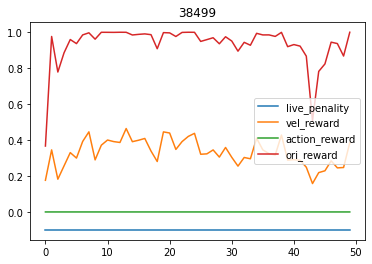

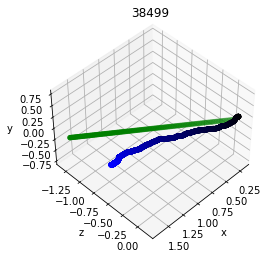

| eval  | E: 769 | S: 38499 | R: 58.1704
| train | E: 770 | S: 38499 | R: 56.1071 | D: 36.5 s | BR: 0.8110 | ALOSS: -38.7532 | CLOSS: 27.2021 | TLOSS: 0.0294 | TVAL: 0.0446 | AENT: -4.0000
| train | E: 771 | S: 38549 | R: 58.2576 | D: 75.5 s | BR: 0.8154 | ALOSS: -39.0339 | CLOSS: 24.1034 | TLOSS: -0.2614 | TVAL: 0.0446 | AENT: -4.0000
| train | E: 772 | S: 38599 | R: 59.5893 | D: 36.0 s | BR: 0.8157 | ALOSS: -39.3005 | CLOSS: 19.3255 | TLOSS: -0.0933 | TVAL: 0.0445 | AENT: -4.0000
| train | E: 773 | S: 38649 | R: 48.9769 | D: 37.3 s | BR: 0.8087 | ALOSS: -39.1280 | CLOSS: 24.0111 | TLOSS: -0.0428 | TVAL: 0.0445 | AENT: -4.0000
| train | E: 774 | S: 38699 | R: 49.7436 | D: 36.5 s | BR: 0.8192 | ALOSS: -39.2188 | CLOSS: 22.2270 | TLOSS: -0.5111 | TVAL: 0.0444 | AENT: -4.0000
| train | E: 775 | S: 38749 | R: 52.1735 | D: 38.8 s | BR: 0.8289 | ALOSS: -39.1739 | CLOSS: 21.3880 | TLOSS: -0.0323 | TVAL: 0.0442 | AENT: -4.0000
| train | E: 776 | S: 38799 | R: 52.1718 | D: 35.9 s | BR: 0.8130 

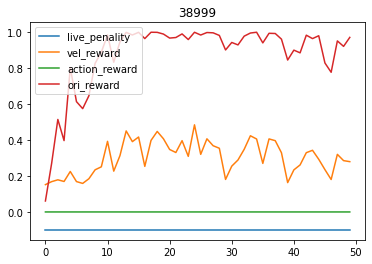

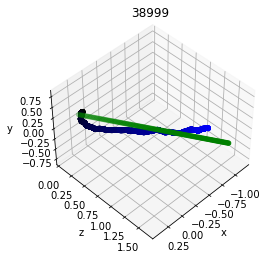

| eval  | E: 779 | S: 38999 | R: 53.9399
| train | E: 780 | S: 38999 | R: 52.0878 | D: 35.8 s | BR: 0.8172 | ALOSS: -39.2208 | CLOSS: 23.2765 | TLOSS: 0.1739 | TVAL: 0.0447 | AENT: -4.0000
| train | E: 781 | S: 39049 | R: 53.9066 | D: 72.0 s | BR: 0.8137 | ALOSS: -39.0809 | CLOSS: 28.6657 | TLOSS: 1.1981 | TVAL: 0.0449 | AENT: -4.0000
| train | E: 782 | S: 39099 | R: 58.3848 | D: 36.1 s | BR: 0.8062 | ALOSS: -39.2086 | CLOSS: 24.4989 | TLOSS: 0.5899 | TVAL: 0.0454 | AENT: -4.0000
| train | E: 783 | S: 39149 | R: 52.9822 | D: 36.2 s | BR: 0.8328 | ALOSS: -39.5950 | CLOSS: 19.2142 | TLOSS: -0.0413 | TVAL: 0.0455 | AENT: -4.0000
| train | E: 784 | S: 39199 | R: 54.8774 | D: 35.8 s | BR: 0.8216 | ALOSS: -39.7138 | CLOSS: 28.5467 | TLOSS: 0.8084 | TVAL: 0.0456 | AENT: -4.0000
| train | E: 785 | S: 39249 | R: 47.0576 | D: 36.7 s | BR: 0.8279 | ALOSS: -39.3479 | CLOSS: 25.4596 | TLOSS: 0.1552 | TVAL: 0.0458 | AENT: -4.0000
| train | E: 786 | S: 39299 | R: 54.0418 | D: 36.4 s | BR: 0.8352 | AL

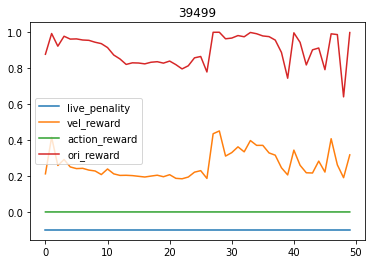

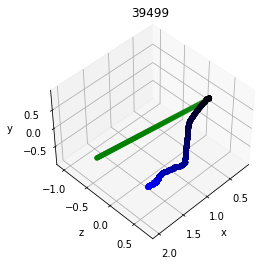

| eval  | E: 789 | S: 39499 | R: 53.3121
| train | E: 790 | S: 39499 | R: 49.9787 | D: 36.3 s | BR: 0.8249 | ALOSS: -39.7878 | CLOSS: 23.7296 | TLOSS: 0.5941 | TVAL: 0.0478 | AENT: -4.0000
| train | E: 791 | S: 39549 | R: 51.5633 | D: 73.6 s | BR: 0.8197 | ALOSS: -39.4265 | CLOSS: 22.7399 | TLOSS: 0.7144 | TVAL: 0.0480 | AENT: -4.0000
| train | E: 792 | S: 39599 | R: 56.5526 | D: 36.1 s | BR: 0.8245 | ALOSS: -39.6115 | CLOSS: 22.7582 | TLOSS: -0.0365 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 793 | S: 39649 | R: 52.6620 | D: 37.1 s | BR: 0.8162 | ALOSS: -39.5716 | CLOSS: 23.3538 | TLOSS: 0.9033 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 794 | S: 39699 | R: 53.2901 | D: 37.7 s | BR: 0.8261 | ALOSS: -39.5791 | CLOSS: 24.4185 | TLOSS: 1.1245 | TVAL: 0.0488 | AENT: -4.0000
| train | E: 795 | S: 39749 | R: 52.4736 | D: 34.0 s | BR: 0.8226 | ALOSS: -39.7770 | CLOSS: 22.6722 | TLOSS: 0.5904 | TVAL: 0.0492 | AENT: -4.0000
| train | E: 796 | S: 39799 | R: 54.4673 | D: 36.2 s | BR: 0.8386 | AL

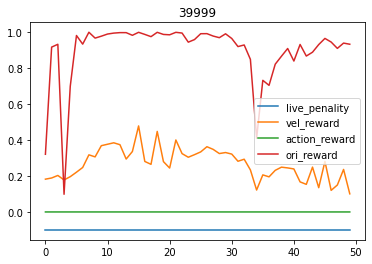

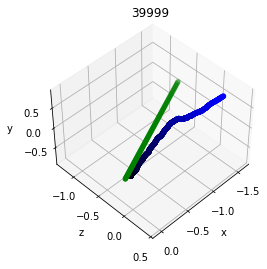

| eval  | E: 799 | S: 39999 | R: 53.2463
| train | E: 800 | S: 39999 | R: 50.4174 | D: 36.2 s | BR: 0.8097 | ALOSS: -39.5120 | CLOSS: 28.2762 | TLOSS: 0.4371 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 801 | S: 40049 | R: 45.6720 | D: 79.0 s | BR: 0.8427 | ALOSS: -40.0707 | CLOSS: 23.2260 | TLOSS: -0.1718 | TVAL: 0.0516 | AENT: -4.0000
| train | E: 802 | S: 40099 | R: 56.1900 | D: 36.1 s | BR: 0.8186 | ALOSS: -39.5832 | CLOSS: 29.6034 | TLOSS: -0.1172 | TVAL: 0.0515 | AENT: -4.0000
| train | E: 803 | S: 40149 | R: 34.9361 | D: 36.1 s | BR: 0.8246 | ALOSS: -39.3512 | CLOSS: 30.9087 | TLOSS: -0.6151 | TVAL: 0.0513 | AENT: -4.0000
| train | E: 804 | S: 40199 | R: 54.9959 | D: 37.0 s | BR: 0.8191 | ALOSS: -39.4000 | CLOSS: 26.4856 | TLOSS: 0.3810 | TVAL: 0.0512 | AENT: -4.0000
| train | E: 805 | S: 40249 | R: 57.3206 | D: 36.0 s | BR: 0.8380 | ALOSS: -39.7199 | CLOSS: 24.8647 | TLOSS: 0.8974 | TVAL: 0.0514 | AENT: -4.0000
| train | E: 806 | S: 40299 | R: 49.0422 | D: 35.9 s | BR: 0.8195 | 

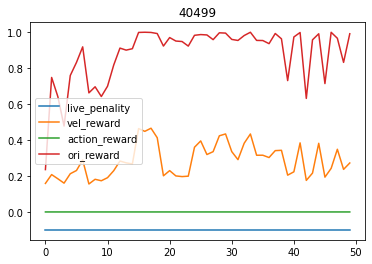

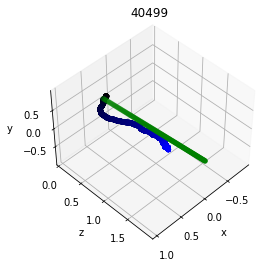

| eval  | E: 809 | S: 40499 | R: 53.1779
| train | E: 810 | S: 40499 | R: 52.5528 | D: 39.7 s | BR: 0.8405 | ALOSS: -39.7488 | CLOSS: 21.6054 | TLOSS: -0.1401 | TVAL: 0.0508 | AENT: -4.0000
| train | E: 811 | S: 40549 | R: 54.0183 | D: 73.1 s | BR: 0.8134 | ALOSS: -39.3031 | CLOSS: 24.6664 | TLOSS: 0.3520 | TVAL: 0.0507 | AENT: -4.0000
| train | E: 812 | S: 40599 | R: 56.5956 | D: 35.7 s | BR: 0.8394 | ALOSS: -39.7342 | CLOSS: 24.9387 | TLOSS: -0.6774 | TVAL: 0.0507 | AENT: -4.0000
| train | E: 813 | S: 40649 | R: 60.5481 | D: 39.1 s | BR: 0.8320 | ALOSS: -39.6505 | CLOSS: 33.9811 | TLOSS: 0.6467 | TVAL: 0.0506 | AENT: -4.0000
| train | E: 814 | S: 40699 | R: 43.2636 | D: 35.9 s | BR: 0.8222 | ALOSS: -39.5351 | CLOSS: 23.6980 | TLOSS: 0.2704 | TVAL: 0.0510 | AENT: -4.0000
| train | E: 815 | S: 40749 | R: 40.3469 | D: 37.6 s | BR: 0.8287 | ALOSS: -39.3909 | CLOSS: 26.6400 | TLOSS: -0.5727 | TVAL: 0.0509 | AENT: -4.0000
| train | E: 816 | S: 40799 | R: 52.8514 | D: 35.4 s | BR: 0.8363 | 

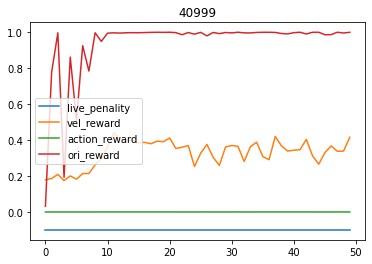

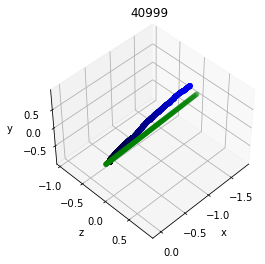

| eval  | E: 819 | S: 40999 | R: 58.2589
| train | E: 820 | S: 40999 | R: 53.3788 | D: 35.7 s | BR: 0.8270 | ALOSS: -39.7862 | CLOSS: 27.9525 | TLOSS: -0.1900 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 821 | S: 41049 | R: 57.2257 | D: 72.7 s | BR: 0.8212 | ALOSS: -39.4145 | CLOSS: 24.2665 | TLOSS: -0.3638 | TVAL: 0.0500 | AENT: -4.0000
| train | E: 822 | S: 41099 | R: 57.3711 | D: 35.8 s | BR: 0.8301 | ALOSS: -39.6071 | CLOSS: 25.8823 | TLOSS: 0.9677 | TVAL: 0.0500 | AENT: -4.0000
| train | E: 823 | S: 41149 | R: 57.5839 | D: 35.7 s | BR: 0.8304 | ALOSS: -39.0515 | CLOSS: 31.7010 | TLOSS: 0.1939 | TVAL: 0.0504 | AENT: -4.0000
| train | E: 824 | S: 41199 | R: 57.1673 | D: 36.5 s | BR: 0.8335 | ALOSS: -39.4351 | CLOSS: 23.6596 | TLOSS: -0.7840 | TVAL: 0.0503 | AENT: -4.0000
| train | E: 825 | S: 41249 | R: 53.4497 | D: 37.5 s | BR: 0.8249 | ALOSS: -39.6061 | CLOSS: 26.1596 | TLOSS: 0.1537 | TVAL: 0.0501 | AENT: -4.0000
| train | E: 826 | S: 41299 | R: 50.9487 | D: 36.2 s | BR: 0.8268 | 

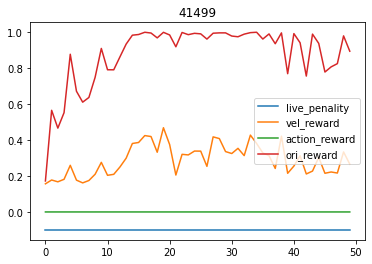

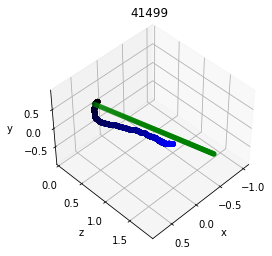

| eval  | E: 829 | S: 41499 | R: 53.3605
| train | E: 830 | S: 41499 | R: 51.5911 | D: 36.0 s | BR: 0.8275 | ALOSS: -39.4093 | CLOSS: 27.2639 | TLOSS: -0.3982 | TVAL: 0.0489 | AENT: -4.0000
| train | E: 831 | S: 41549 | R: 55.6696 | D: 72.2 s | BR: 0.8321 | ALOSS: -38.8734 | CLOSS: 31.5055 | TLOSS: -0.6431 | TVAL: 0.0487 | AENT: -4.0000
| train | E: 832 | S: 41599 | R: 40.5964 | D: 35.8 s | BR: 0.8338 | ALOSS: -39.4083 | CLOSS: 21.8926 | TLOSS: -0.6644 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 833 | S: 41649 | R: 58.3237 | D: 38.3 s | BR: 0.8181 | ALOSS: -39.1809 | CLOSS: 22.9007 | TLOSS: -0.3019 | TVAL: 0.0482 | AENT: -4.0000
| train | E: 834 | S: 41699 | R: 51.9301 | D: 35.8 s | BR: 0.8276 | ALOSS: -39.1367 | CLOSS: 28.4569 | TLOSS: -0.2166 | TVAL: 0.0479 | AENT: -4.0000
| train | E: 835 | S: 41749 | R: 52.5186 | D: 35.7 s | BR: 0.8553 | ALOSS: -39.7703 | CLOSS: 24.4683 | TLOSS: -0.4952 | TVAL: 0.0478 | AENT: -4.0000
| train | E: 836 | S: 41799 | R: 50.8651 | D: 36.0 s | BR: 0.8261

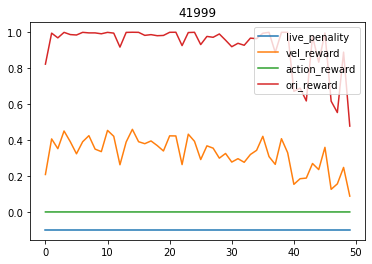

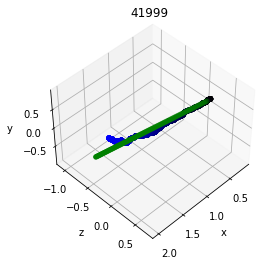

| eval  | E: 839 | S: 41999 | R: 57.5690
| train | E: 840 | S: 41999 | R: 46.0931 | D: 37.9 s | BR: 0.8440 | ALOSS: -39.4281 | CLOSS: 26.4631 | TLOSS: 0.0578 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 841 | S: 42049 | R: 53.9529 | D: 85.8 s | BR: 0.8460 | ALOSS: -39.4323 | CLOSS: 25.1315 | TLOSS: -0.3619 | TVAL: 0.0468 | AENT: -4.0000
| train | E: 842 | S: 42099 | R: 51.8308 | D: 42.3 s | BR: 0.8444 | ALOSS: -39.4423 | CLOSS: 25.6370 | TLOSS: 0.3949 | TVAL: 0.0468 | AENT: -4.0000
| train | E: 843 | S: 42149 | R: 59.9886 | D: 45.0 s | BR: 0.8480 | ALOSS: -39.2528 | CLOSS: 28.2923 | TLOSS: -0.1178 | TVAL: 0.0470 | AENT: -4.0000
| train | E: 844 | S: 42199 | R: 56.7487 | D: 44.0 s | BR: 0.8337 | ALOSS: -38.9743 | CLOSS: 28.5662 | TLOSS: -0.7749 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 845 | S: 42249 | R: 52.2115 | D: 42.1 s | BR: 0.8453 | ALOSS: -39.5761 | CLOSS: 20.8087 | TLOSS: -0.6273 | TVAL: 0.0465 | AENT: -4.0000
| train | E: 846 | S: 42299 | R: 60.0170 | D: 42.5 s | BR: 0.8446 |

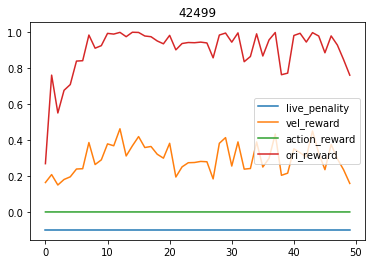

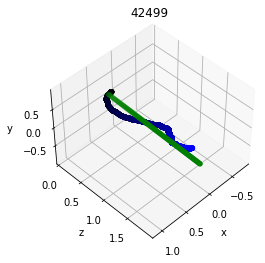

| eval  | E: 849 | S: 42499 | R: 54.8544
| train | E: 850 | S: 42499 | R: 51.8377 | D: 42.4 s | BR: 0.8538 | ALOSS: -39.4409 | CLOSS: 21.7361 | TLOSS: 0.2171 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 851 | S: 42549 | R: 41.5134 | D: 83.9 s | BR: 0.8470 | ALOSS: -39.4121 | CLOSS: 29.8884 | TLOSS: -0.5711 | TVAL: 0.0467 | AENT: -4.0000
| train | E: 852 | S: 42599 | R: 57.5125 | D: 45.8 s | BR: 0.8324 | ALOSS: -39.1771 | CLOSS: 29.2273 | TLOSS: 0.0960 | TVAL: 0.0466 | AENT: -4.0000
| train | E: 853 | S: 42649 | R: 53.8988 | D: 46.5 s | BR: 0.8504 | ALOSS: -39.2408 | CLOSS: 24.1998 | TLOSS: -0.8846 | TVAL: 0.0463 | AENT: -4.0000
| train | E: 854 | S: 42699 | R: 53.8681 | D: 42.6 s | BR: 0.8307 | ALOSS: -39.1039 | CLOSS: 28.1767 | TLOSS: 0.8301 | TVAL: 0.0463 | AENT: -4.0000
| train | E: 855 | S: 42749 | R: 60.3660 | D: 42.5 s | BR: 0.8474 | ALOSS: -39.2344 | CLOSS: 26.3829 | TLOSS: 0.0201 | TVAL: 0.0465 | AENT: -4.0000
| train | E: 856 | S: 42799 | R: 54.7423 | D: 42.9 s | BR: 0.8336 | A

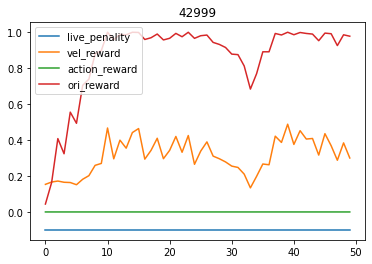

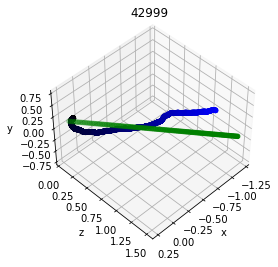

| eval  | E: 859 | S: 42999 | R: 53.9055
| train | E: 860 | S: 42999 | R: 52.9467 | D: 42.8 s | BR: 0.8403 | ALOSS: -39.4118 | CLOSS: 19.2136 | TLOSS: 0.5863 | TVAL: 0.0460 | AENT: -4.0000
| train | E: 861 | S: 43049 | R: 56.2076 | D: 88.1 s | BR: 0.8559 | ALOSS: -39.7370 | CLOSS: 23.8206 | TLOSS: -0.1376 | TVAL: 0.0463 | AENT: -4.0000
| train | E: 862 | S: 43099 | R: 51.2239 | D: 42.4 s | BR: 0.8340 | ALOSS: -39.3723 | CLOSS: 19.6676 | TLOSS: -0.4202 | TVAL: 0.0462 | AENT: -4.0000
| train | E: 863 | S: 43149 | R: 55.4707 | D: 42.6 s | BR: 0.8476 | ALOSS: -39.6253 | CLOSS: 19.0413 | TLOSS: -0.3334 | TVAL: 0.0460 | AENT: -4.0000
| train | E: 864 | S: 43199 | R: 54.7043 | D: 44.9 s | BR: 0.8411 | ALOSS: -39.6325 | CLOSS: 29.6075 | TLOSS: 0.3265 | TVAL: 0.0459 | AENT: -4.0000
| train | E: 865 | S: 43249 | R: 56.9826 | D: 39.3 s | BR: 0.8341 | ALOSS: -38.8411 | CLOSS: 32.6052 | TLOSS: 0.5585 | TVAL: 0.0462 | AENT: -4.0000


In [ ]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [26]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [27]:
agent.replay_buffer.full

True

In [41]:
model_folder+'model'

'/root/pytorch_fish/output_data/2021-05-05/test LowLevel _2021-05-05 07:30/networks/SAC/models/model'

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(3.14,0.01)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [29]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [30]:
%matplotlib notebook

In [31]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
env.plot3d()

<IPython.core.display.Javascript object>


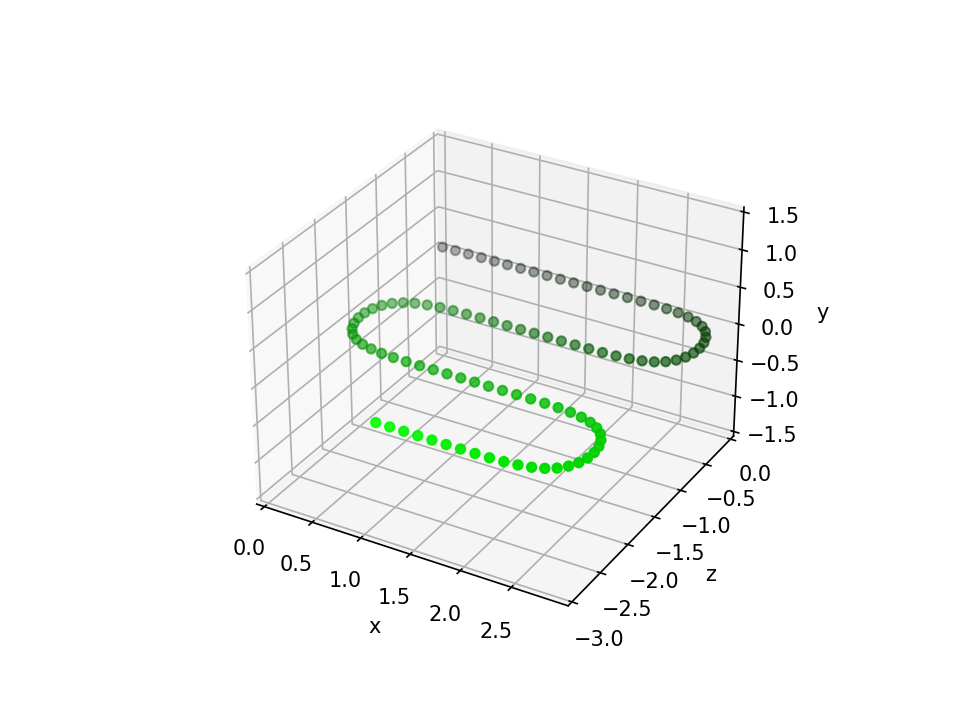

In [32]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [33]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Trajectory/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory
Set task with VEL 0.18767280983903684,GOAL [-0.22984444  0.         -0.97322738]
Set task with VEL 0.3,GOAL [0.71341973 0.         0.        ]


<IPython.core.display.Javascript object>


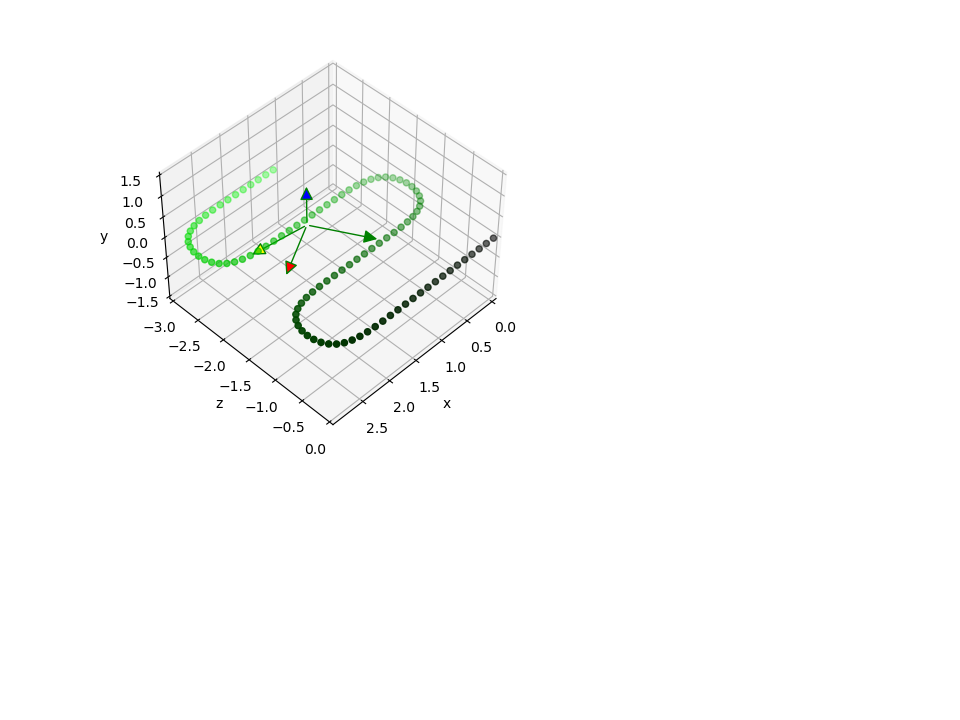

Set task with VEL 0.3,GOAL [0.14139348 0.         0.05612549]
Set task with VEL 0.3,GOAL [0.81237173 0.         0.03842197]
Set task with VEL 0.3,GOAL [0.95931848 0.         0.01138497]
Set task with VEL 0.3,GOAL [ 0.87408037  0.         -0.08969829]
Set task with VEL 0.3,GOAL [ 0.60244323  0.         -0.30648445]
Set task with VEL 0.3,GOAL [ 0.3617409   0.         -0.56756389]
Set task with VEL 0.3,GOAL [ 0.43699092  0.         -0.69355172]
Set task with VEL 0.3,GOAL [ 0.90687787  0.         -0.31358397]
Set task with VEL 0.3,GOAL [0.94093286 0.         0.23523151]
Set task with VEL 0.3,GOAL [0.82215243 0.         0.20637657]
Set task with VEL 0.3,GOAL [0.59141011 0.         0.43080033]
Set task with VEL 0.3,GOAL [0.67016744 0.         0.39112926]
Set task with VEL 0.3,GOAL [0.82720494 0.         0.46813862]
Set task with VEL 0.3,GOAL [ 0.96751645  0.         -0.07404524]
Set task with VEL 0.3,GOAL [0.95035999 0.         0.14901078]


KeyboardInterrupt: 

In [40]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()

t = 0.001
dt = 0.05
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.set_task(goal_pos,0.3)


env.set_datapath(store_folder+'/data/')
# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action = agent.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.step(action,save_objects=True,save_fluid=False)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t= t+dt
        env.init_pos  = env.body_xyz 
        env.set_task( traj.getPose(t).getPosition(),0.3)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**0.5) for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()